In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/applai-26-nn-competition/sample_submission.csv
/kaggle/input/applai-26-nn-competition/train.csv
/kaggle/input/applai-26-nn-competition/test.csv


# Notebook Block 1: Load data, sanity checks, and distribution-shift / unit-mismatch detectors.

In [ ]:
import os
import math
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy.stats import ks_2samp, pearsonr

# utilities
from typing import List, Tuple

# -------------------------
# 1) Load files 
# -------------------------
TRAIN_PATH = "/kaggle/input/applai-26-nn-competition/train.csv" 
TEST_PATH  = "/kaggle/input/applai-26-nn-competition/test.csv"  

assert os.path.exists(TRAIN_PATH), f"Train file not found: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH),  f"Test file not found: {TEST_PATH}"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("Loaded:")
print(" - train:", train.shape)
print(" - test :", test.shape)


Loaded:
 - train: (16512, 10)
 - test : (4128, 9)


In [4]:
# 2) Basic info + quick peek

display(train.head(6))
display(test.head(6))

print("\nTrain dtypes & non-null counts:")
display(pd.DataFrame({"dtype": train.dtypes, "non_null": train.notna().sum()}))

print("\nTest dtypes & non-null counts:")
display(pd.DataFrame({"dtype": test.dtypes, "non_null": test.notna().sum()}))


,ID,Feature_Alpha,Feature_Beta,Feature_Gamma,Feature_Delta,Feature_Epsilon,Feature_Zeta,Feature_Eta,Feature_Theta,Target_Value
0,6560,75.7440,300.0,6.932927,1.036585,6.263398,3.195122,33.90,-117.82,2.593
1,1071,8.3380,52.0,8.297101,0.963768,334.000000,2.420290,38.54,-121.50,4.058
2,11749,28.7500,312.0,5.169761,1.050398,7.362645,4.177719,34.96,-120.45,1.214
3,13991,2.5000,43.0,3.467105,0.875000,367.000000,2.414474,37.96,-121.26,0.636
4,17310,2.0303,40.0,4.925087,1.141115,2037.000000,3.548780,37.94,-121.29,0.638
5,17392,18.8540,360.0,3.798479,1.003802,6.919684,3.844106,37.79,-122.23,1.375


,ID,Feature_Alpha,Feature_Beta,Feature_Gamma,Feature_Delta,Feature_Epsilon,Feature_Zeta,Feature_Eta,Feature_Theta
0,16086,1.7176,34.0,4.501916,0.961686,683.000000,2.616858,36.43,-119.86
1,8816,4.6923,15.0,5.766544,0.935662,1635.000000,3.005515,38.69,-121.33
2,7175,4.1563,20.0,4.735736,1.090090,764.000000,2.294294,33.47,-117.70
3,16714,28.2470,180.0,4.953030,1.035497,8.792398,2.360344,33.15,-117.04
4,14491,21.8750,324.0,5.412429,1.039548,6.364751,3.276836,37.60,-121.04
5,11807,2.1810,36.0,3.399582,1.025105,2003.000000,4.190377,34.04,-118.20



Train dtypes & non-null counts:


,dtype,non_null
ID,int64,16512
Feature_Alpha,float64,16512
Feature_Beta,float64,16512
Feature_Gamma,float64,16512
Feature_Delta,float64,16512
Feature_Epsilon,float64,16512
Feature_Zeta,float64,16512
Feature_Eta,float64,16512
Feature_Theta,float64,16512
Target_Value,float64,16512



Test dtypes & non-null counts:


,dtype,non_null
ID,int64,4128
Feature_Alpha,float64,4128
Feature_Beta,float64,4128
Feature_Gamma,float64,4128
Feature_Delta,float64,4128
Feature_Epsilon,float64,4128
Feature_Zeta,float64,4128
Feature_Eta,float64,4128
Feature_Theta,float64,4128


In [5]:
# 3) Identify feature columns and target

ID_COL = "ID"
TARGET_COL = "Target_Value"   # in train only

all_train_cols = list(train.columns)
features = [c for c in all_train_cols if c not in (ID_COL, TARGET_COL)]

print(f"\nDetected {len(features)} feature columns:", features)


Detected 8 feature columns: ['Feature_Alpha', 'Feature_Beta', 'Feature_Gamma', 'Feature_Delta', 'Feature_Epsilon', 'Feature_Zeta', 'Feature_Eta', 'Feature_Theta']


In [6]:
# 4) Missingness summary

def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().sum().rename("missing_count").to_frame()
    miss["missing_pct"] = miss["missing_count"] / len(df)
    miss = miss.sort_values("missing_count", ascending=False)
    return miss

print("\nMissing values (train):")
display(missing_summary(train))

print("\nMissing values (test):")
display(missing_summary(test))


# Quick heuristic: features present in train but nearly empty in test (or vice versa)
for col in features:
    tr_nonnull = train[col].notna().sum()
    te_nonnull = test[col].notna().sum()
    if te_nonnull == 0:
        print(f"WARNING: feature {col} is completely empty in test (train non-null = {tr_nonnull})")


Missing values (train):


,missing_count,missing_pct
ID,0,0.0
Feature_Alpha,0,0.0
Feature_Beta,0,0.0
Feature_Gamma,0,0.0
Feature_Delta,0,0.0
Feature_Epsilon,0,0.0
Feature_Zeta,0,0.0
Feature_Eta,0,0.0
Feature_Theta,0,0.0
Target_Value,0,0.0



Missing values (test):


,missing_count,missing_pct
ID,0,0.0
Feature_Alpha,0,0.0
Feature_Beta,0,0.0
Feature_Gamma,0,0.0
Feature_Delta,0,0.0
Feature_Epsilon,0,0.0
Feature_Zeta,0,0.0
Feature_Eta,0,0.0
Feature_Theta,0,0.0


In [7]:
# 5) Numeric summary and basic stats (train only)

num_desc = train[features + [TARGET_COL]].describe().T
num_desc["skew"] = train[features + [TARGET_COL]].skew()
num_desc["kurtosis"] = train[features + [TARGET_COL]].kurtosis()
display(num_desc)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Feature_Alpha,16512.0,21.351254,22.076260,0.499900,3.543275,11.156350,35.299500,150.001000,1.396942,2.660535
Feature_Beta,16512.0,185.856831,189.846630,1.000000,29.000000,52.000000,339.000000,624.000000,0.795750,-0.728906
Feature_Gamma,16512.0,5.433598,2.546012,0.888889,4.442464,5.227722,6.048574,141.909091,21.950586,947.381600
Feature_Delta,16512.0,1.097918,0.487780,0.333333,1.006504,1.049367,1.100000,34.066667,32.672074,1743.003317
Feature_Epsilon,16512.0,710.890683,1065.591731,1.386294,7.066467,8.908012,1158.000000,28566.000000,3.861847,43.927605
Feature_Zeta,16512.0,3.097123,11.584209,0.692308,2.427300,2.815672,3.279435,1243.333333,87.934492,8601.944930
Feature_Eta,16512.0,35.634361,2.141151,32.550000,33.930000,34.250000,37.720000,41.950000,0.471307,-1.111821
Feature_Theta,16512.0,-119.570038,2.008733,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000,-0.298042,-1.325724
Target_Value,16512.0,2.067068,1.151890,0.149990,1.194000,1.797000,2.642000,5.000010,0.979944,0.339296


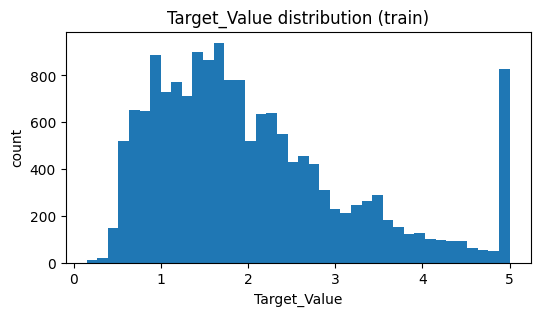

,abs_pearson_with_target
Feature_Alpha,0.325051
Feature_Gamma,0.147853
Feature_Eta,0.144372
Feature_Theta,0.045847
Feature_Delta,0.044647
Feature_Beta,0.043754
Feature_Zeta,0.021985
Feature_Epsilon,0.012592


In [8]:
# 6) Target distribution & top correlations

if TARGET_COL in train.columns:
    plt.figure(figsize=(6,3))
    plt.hist(train[TARGET_COL], bins=40)
    plt.title("Target_Value distribution (train)")
    plt.xlabel("Target_Value")
    plt.ylabel("count")
    plt.show()

# compute Pearson correlations with target (ignoring NaNs)
corrs = {}
for col in features:
    try:
        valid = train[[col, TARGET_COL]].dropna()
        if len(valid) > 10:
            cor, _ = pearsonr(valid[col], valid[TARGET_COL])
            corrs[col] = cor
    except Exception:
        corrs[col] = np.nan

corr_df = pd.Series(corrs).abs().sort_values(ascending=False).rename("abs_pearson_with_target")
display(corr_df.to_frame().head(10))


In [9]:
# 7) Distribution-shift tests between train and test for each feature
#    - median ratio (test vs train)
#    - KS two-sample test (statistic + p-value)
#    - simple bimodality detector (histogram peaks)
#    - variance ratio

def detect_feature_shift(train: pd.DataFrame, test: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    rows = []
    for col in features:
        tr_col = train[col].dropna()
        te_col = test[col].dropna() if col in test.columns else pd.Series(dtype=float)
        row = {"feature": col,
               "train_nonnull": len(tr_col),
               "test_nonnull": len(te_col),
               "train_median": tr_col.median() if len(tr_col)>0 else np.nan,
               "test_median": te_col.median() if len(te_col)>0 else np.nan,
               "train_std": tr_col.std() if len(tr_col)>0 else np.nan,
               "test_std": te_col.std() if len(te_col)>0 else np.nan}
        # median ratio (avoid division by zero)
        if not pd.isna(row["train_median"]) and row["train_median"] != 0 and not pd.isna(row["test_median"]):
            row["median_ratio_test_over_train"] = row["test_median"] / row["train_median"]
        else:
            row["median_ratio_test_over_train"] = np.nan
        # variance ratio
        if not pd.isna(row["train_std"]) and row["train_std"] > 1e-12:
            row["std_ratio_test_over_train"] = (row["test_std"] / row["train_std"]) if not pd.isna(row["test_std"]) else np.nan
        else:
            row["std_ratio_test_over_train"] = np.nan
        # KS test (only if both have enough samples)
        try:
            if len(tr_col) >= 20 and len(te_col) >= 20:
                ks_stat, ks_p = ks_2samp(tr_col, te_col)
                row["ks_stat"] = float(ks_stat)
                row["ks_pvalue"] = float(ks_p)
            else:
                row["ks_stat"] = np.nan
                row["ks_pvalue"] = np.nan
        except Exception:
            row["ks_stat"] = np.nan
            row["ks_pvalue"] = np.nan

        # simple bimodality heuristic: find peaks in histogram
        try:
            hist, edges = np.histogram(np.concatenate([tr_col.values, te_col.values]) if len(te_col)>0 else tr_col.values, bins=50)
            peaks = np.where((hist[1:-1] > hist[:-2]) & (hist[1:-1] > hist[2:]))[0]
            peaks_count = len(peaks)
            row["hist_peaks"] = peaks_count
        except Exception:
            row["hist_peaks"] = np.nan

        rows.append(row)
    return pd.DataFrame(rows).set_index("feature")

shift_df = detect_feature_shift(train, test, features)
# sort by indicators likely to show mismatch
display(shift_df.sort_values(by=["median_ratio_test_over_train"], key=lambda s: s.abs(), ascending=False).head(12))
display(shift_df.sort_values(by="ks_stat", ascending=False).head(12))


,train_nonnull,test_nonnull,train_median,test_median,train_std,test_std,median_ratio_test_over_train,std_ratio_test_over_train,ks_stat,ks_pvalue,hist_peaks
feature,,,,,,,,,,,
Feature_Epsilon,16512,4128,8.908012,163.000000,1065.591731,1070.645913,18.298135,1.004743,0.012294,0.695650,4
Feature_Zeta,16512,4128,2.815672,2.833333,11.584209,1.602358,1.006273,0.138323,0.015625,0.391699,3
Feature_Gamma,16512,4128,5.227722,5.233333,2.546012,2.163273,1.001073,0.849671,0.010780,0.833417,5
Feature_Eta,16512,4128,34.250000,34.260000,2.141151,2.115257,1.000292,0.987906,0.014595,0.478195,13
Feature_Theta,16512,4128,-118.490000,-118.520000,2.008733,1.982832,1.000253,0.987106,0.010477,0.857699,13
Feature_Beta,16512,4128,52.000000,52.000000,189.846630,190.140093,1.000000,1.001546,0.013384,0.590332,10
Feature_Delta,16512,4128,1.049367,1.046746,0.487780,0.413828,0.997502,0.848390,0.027253,0.014546,6
Feature_Alpha,16512,4128,11.156350,8.508200,22.076260,22.129534,0.762633,1.002413,0.013748,0.555804,10


,train_nonnull,test_nonnull,train_median,test_median,train_std,test_std,median_ratio_test_over_train,std_ratio_test_over_train,ks_stat,ks_pvalue,hist_peaks
feature,,,,,,,,,,,
Feature_Delta,16512,4128,1.049367,1.046746,0.487780,0.413828,0.997502,0.848390,0.027253,0.014546,6
Feature_Zeta,16512,4128,2.815672,2.833333,11.584209,1.602358,1.006273,0.138323,0.015625,0.391699,3
Feature_Eta,16512,4128,34.250000,34.260000,2.141151,2.115257,1.000292,0.987906,0.014595,0.478195,13
Feature_Alpha,16512,4128,11.156350,8.508200,22.076260,22.129534,0.762633,1.002413,0.013748,0.555804,10
Feature_Beta,16512,4128,52.000000,52.000000,189.846630,190.140093,1.000000,1.001546,0.013384,0.590332,10
Feature_Epsilon,16512,4128,8.908012,163.000000,1065.591731,1070.645913,18.298135,1.004743,0.012294,0.695650,4
Feature_Gamma,16512,4128,5.227722,5.233333,2.546012,2.163273,1.001073,0.849671,0.010780,0.833417,5
Feature_Theta,16512,4128,-118.490000,-118.520000,2.008733,1.982832,1.000253,0.987106,0.010477,0.857699,13


In [10]:
# 8) Flag features that probably need "unit alignment" or special preprocessing
#    Criteria (heuristic):
#      - median_ratio_test_over_train magnitude > 3  (test medians very different)
#      - OR ks_stat > 0.2 (large distributional change)
#      - OR hist_peaks >= 2 (possible bimodality)
#      - OR test_nonnull is much smaller than train_nonnull (missingness)

def flag_features_for_attention(shift_df: pd.DataFrame, ratio_thresh: float = 3.0, ks_thresh: float = 0.2) -> pd.Series:
    flags = []
    for idx, r in shift_df.iterrows():
        f = False
        reasons = []
        mr = r.get("median_ratio_test_over_train", np.nan)
        if (not pd.isna(mr)) and (abs(mr) > ratio_thresh):
            f = True
            reasons.append(f"median_ratio={mr:.2f}")
        if (not pd.isna(r.get("ks_stat"))) and (r.get("ks_stat") > ks_thresh):
            f = True
            reasons.append(f"ks_stat={r.get('ks_stat'):.3f}")
        if (not pd.isna(r.get("hist_peaks"))) and (r.get("hist_peaks") >= 2):
            f = True
            reasons.append(f"hist_peaks={int(r.get('hist_peaks'))}")
        if r.get("test_nonnull", 0) < 0.2 * r.get("train_nonnull", 1):
            f = True
            reasons.append(f"missing_in_test ({int(r.get('test_nonnull'))}/{int(r.get('train_nonnull'))})")
        flags.append({"feature": idx, "flagged": f, "reasons": "; ".join(reasons)})
    return pd.DataFrame(flags).set_index("feature")

flags = flag_features_for_attention(shift_df)
display(flags[flags["flagged"]])

,flagged,reasons
feature,,
Feature_Alpha,True,hist_peaks=10
Feature_Beta,True,hist_peaks=10
Feature_Gamma,True,hist_peaks=5
Feature_Delta,True,hist_peaks=6
Feature_Epsilon,True,median_ratio=18.30; hist_peaks=4
Feature_Zeta,True,hist_peaks=3
Feature_Eta,True,hist_peaks=13
Feature_Theta,True,hist_peaks=13


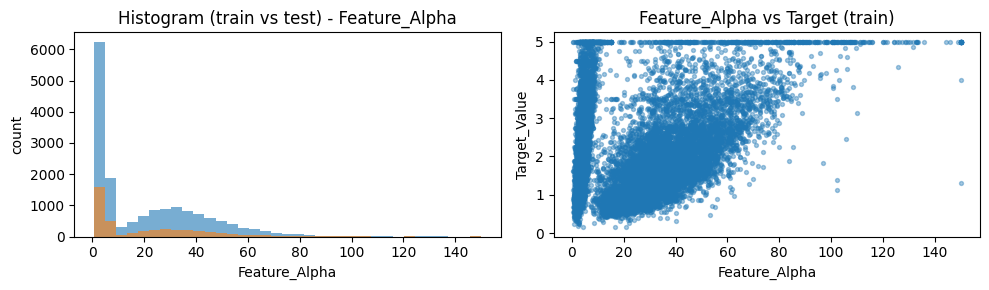

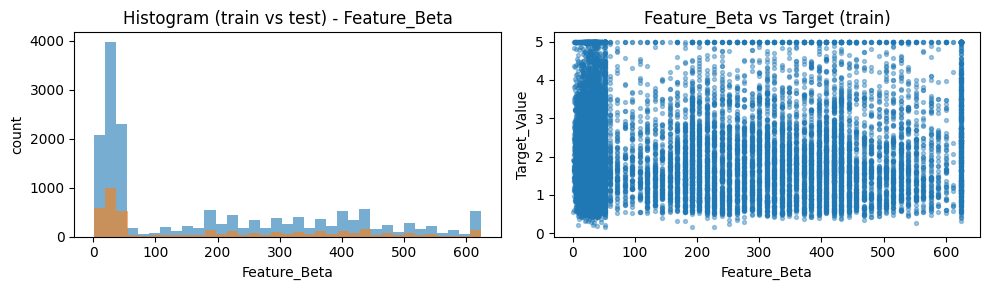

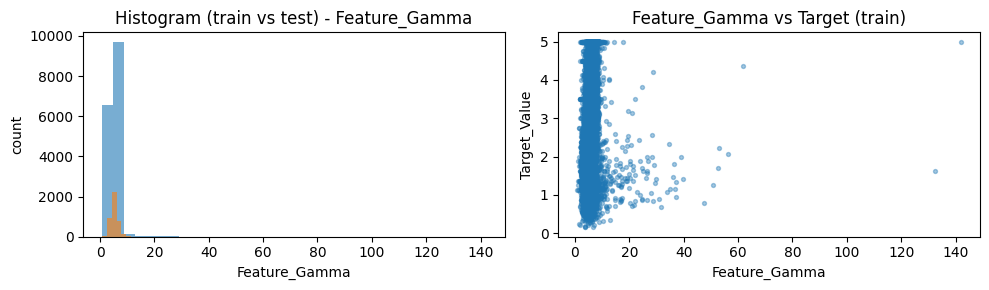

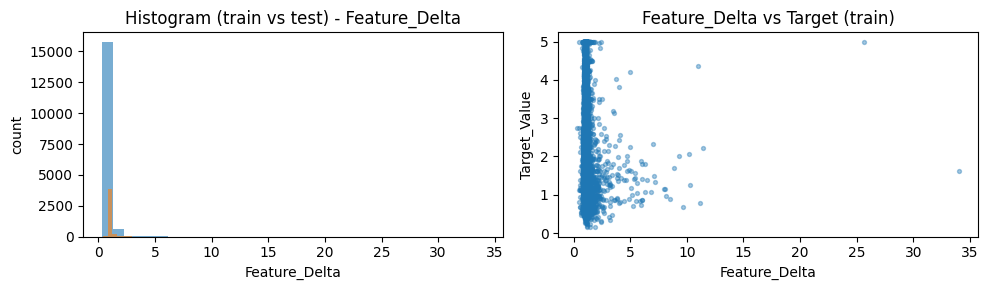

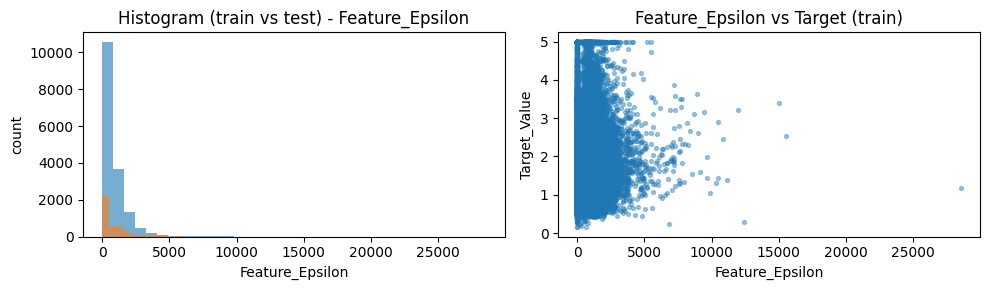

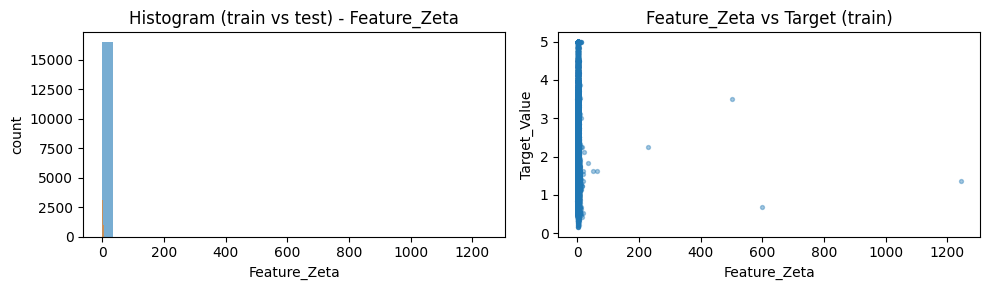

In [11]:
# 9) Visual quick-plots for flagged features (up to 6)

flagged = list(flags[flags["flagged"]].index)[:6]
if flagged:
    for col in flagged:
        plt.figure(figsize=(10,3))
        # overlay train and test histograms
        a = train[col].dropna()
        b = test[col].dropna() if col in test.columns else pd.Series(dtype=float)
        plt.subplot(1,2,1)
        plt.hist(a, bins=35, alpha=0.6)
        if len(b) > 0:
            plt.hist(b, bins=35, alpha=0.6)
        plt.title(f"Histogram (train vs test) - {col}")
        plt.xlabel(col)
        plt.ylabel("count")
        # scatter vs target (train only)
        plt.subplot(1,2,2)
        if TARGET_COL in train.columns:
            plt.scatter(a, train.loc[a.index, TARGET_COL], alpha=0.4, s=8)
            plt.title(f"{col} vs Target (train)")
            plt.xlabel(col)
            plt.ylabel("Target_Value")
        plt.tight_layout()
        plt.show()
else:
    print("No features flagged by heuristics. Still inspect features manually.")

In [12]:
# 10) Save the shift summary for later steps (CSV)

shift_df.to_csv("feature_shift_summary.csv")
flags.to_csv("feature_shift_flags.csv")
print("Saved: feature_shift_summary.csv, feature_shift_flags.csv")

Saved: feature_shift_summary.csv, feature_shift_flags.csv


# Notebook Block 2: Preprocessing pipeline -- unit alignment, bimodal handling, imputing, transforms, scaling

In [13]:
import os
import numpy as np
import pandas as pd
from typing import List, Dict

# sklearn utilities
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from scipy.stats import ks_2samp
import joblib    # reliable joblib
import warnings
warnings.filterwarnings("ignore")


# CONFIG / PATHS (adjust if needed)
TRAIN_PATH = "/kaggle/input/applai-26-nn-competition/train.csv"
TEST_PATH  = "/kaggle/input/applai-26-nn-competition/test.csv"
SHIFT_SUMMARY_CSV = "feature_shift_summary.csv"   # produced by Block 1
FLAGS_CSV = "feature_shift_flags.csv"             # produced by Block 1
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

ID_COL = "ID"
TARGET_COL = "Target_Value"

# thresholds (tweakable)
UNIT_RATIO_THRESHOLD = 3.0   # used by UnitAligner to decide alignment
MIN_SAMPLES_FOR_ALIGN = 30   # min samples to attempt fitting GMM for a col
MIN_SAMPLES_FOR_KMEANS = 30  # min samples to attempt KMeans for a col
CLIP_LOW, CLIP_HIGH = 0.01, 0.99

In [14]:
# 0) Load data and saved detection CSVs from Block 1

assert os.path.exists(TRAIN_PATH), f"train file not found: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH), f"test file not found: {TEST_PATH}"
assert os.path.exists(SHIFT_SUMMARY_CSV), f"shift summary CSV missing: {SHIFT_SUMMARY_CSV}"
assert os.path.exists(FLAGS_CSV), f"flags CSV missing: {FLAGS_CSV}"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
shift_df = pd.read_csv(SHIFT_SUMMARY_CSV, index_col=0)
flags_df = pd.read_csv(FLAGS_CSV, index_col=0)

features = [c for c in train.columns if c not in (ID_COL, TARGET_COL)]
print("Loaded data. Features:", features)


Loaded data. Features: ['Feature_Alpha', 'Feature_Beta', 'Feature_Gamma', 'Feature_Delta', 'Feature_Epsilon', 'Feature_Zeta', 'Feature_Eta', 'Feature_Theta']


In [15]:
# 1) Decide which columns need special handling based on Block 1 flags (no re-detection)
#    - bimodal_cols: those flagged with hist_peaks >= 2 (or reasons contains 'hist_peaks')
#    - align_candidate_cols: those flagged with median_ratio or large median_ratio in shift_df
# use flags_df.reasons if available
bimodal_cols = []
align_candidate_cols = []

# parse reasons safely (some rows may have NaN)
for feat in features:
    reasons = ""
    if feat in flags_df.index:
        reasons = str(flags_df.loc[feat, "reasons"])
    # bimodal if reason mentions hist_peaks or if shift_df hist_peaks >= 2
    if ("hist_peaks" in reasons and ("=" in reasons or reasons.count("hist_peaks")>0)) or \
       (feat in shift_df.index and not np.isnan(shift_df.loc[feat, "hist_peaks"]) and shift_df.loc[feat, "hist_peaks"] >= 2):
        bimodal_cols.append(feat)
    # align candidates if reason has median_ratio OR shift_df shows big ratio
    mr = shift_df.loc[feat, "median_ratio_test_over_train"] if (feat in shift_df.index) else np.nan
    if ("median_ratio" in reasons) or (not pd.isna(mr) and abs(mr) > UNIT_RATIO_THRESHOLD):
        align_candidate_cols.append(feat)

# fallback if lists empty: be conservative - try aligning only features with large median ratio in shift_df
if len(align_candidate_cols) == 0:
    align_candidate_cols = [f for f in features if (f in shift_df.index and not pd.isna(shift_df.loc[f,"median_ratio_test_over_train"]) and abs(shift_df.loc[f,"median_ratio_test_over_train"])>UNIT_RATIO_THRESHOLD)]

print("Bimodal columns (selected):", bimodal_cols)
print("Align-candidate columns (selected):", align_candidate_cols)

Bimodal columns (selected): ['Feature_Alpha', 'Feature_Beta', 'Feature_Gamma', 'Feature_Delta', 'Feature_Epsilon', 'Feature_Zeta', 'Feature_Eta', 'Feature_Theta']
Align-candidate columns (selected): ['Feature_Epsilon']


In [16]:
# 2) Custom Transformers (lightweight versions)
#    UnitAligner: fits GMM(2) on selected cols and scales values in larger-mean cluster by ratio
#    BimodalSplitter: fits KMeans(2) on selected cols and produces <col>__mode indicator
#    Clipper: compute train percentiles and clip

class UnitAligner(BaseEstimator, TransformerMixin):
    def __init__(self, columns: List[str], ratio_thresh: float = UNIT_RATIO_THRESHOLD, min_samples:int=MIN_SAMPLES_FOR_ALIGN, random_state: int = 42):
        self.columns = columns
        self.ratio_thresh = ratio_thresh
        self.min_samples = min_samples
        self.random_state = random_state
        self.params_ = {}

    def fit(self, X, y=None):
        # X is expected DataFrame with columns containing numeric columns
        for col in self.columns:
            col_vals = X[col].dropna().values.reshape(-1,1)
            if len(col_vals) < self.min_samples:
                self.params_[col] = {"align": False}
                continue
            try:
                gmm = GaussianMixture(n_components=2, random_state=self.random_state)
                gmm.fit(col_vals)
                means = gmm.means_.ravel()
                low, high = np.sort(means)[0], np.sort(means)[1]
                if low <= 0:
                    ratio = np.inf
                else:
                    ratio = high / low
                if ratio > self.ratio_thresh and low > 0:
                    # align: scale down values in cluster with higher mean
                    higher_idx = int(np.argmax(means))
                    self.params_[col] = {"align": True, "gmm": gmm, "scale_ratio": float(ratio), "higher_idx": higher_idx}
                else:
                    self.params_[col] = {"align": False, "gmm": gmm, "scale_ratio": float(ratio)}
            except Exception:
                self.params_[col] = {"align": False}
        return self

    def transform(self, X):
        X = X.copy()
        for col, p in self.params_.items():
            if not p.get("align", False):
                continue
            nonnull = X[col].notna()
            if nonnull.sum() == 0:
                continue
            vals = X.loc[nonnull, col].values.reshape(-1,1)
            labels = p["gmm"].predict(vals)
            mask = (labels == p["higher_idx"])
            scaled_vals = vals.astype(float)
            scaled_vals[mask] = scaled_vals[mask] / p["scale_ratio"]
            X.loc[nonnull, col] = scaled_vals.ravel()
        return X

class BimodalSplitter(BaseEstimator, TransformerMixin):
    def __init__(self, columns: List[str], min_samples: int = MIN_SAMPLES_FOR_KMEANS):
        self.columns = columns
        self.min_samples = min_samples
        self.km_map = {}

    def fit(self, X, y=None):
        for col in self.columns:
            vals = X[col].dropna().values.reshape(-1,1)
            if len(vals) < self.min_samples:
                self.km_map[col] = None
                continue
            try:
                km = KMeans(n_clusters=2, random_state=42).fit(vals)
                self.km_map[col] = km
            except Exception:
                self.km_map[col] = None
        return self

    def transform(self, X):
        Xout = X.copy()
        for col, km in self.km_map.items():
            indicator_name = f"{col}__mode"
            if km is None:
                Xout[indicator_name] = 0
                continue
            nonnull = Xout[col].notna()
            if nonnull.sum() == 0:
                Xout[indicator_name] = 0
                continue
            labels = km.predict(Xout.loc[nonnull, col].values.reshape(-1,1))
            centers = km.cluster_centers_.ravel()
            larger_cluster = int(np.argmax(centers))
            idx_vec = np.zeros(len(Xout), dtype=int)
            idx_vec[nonnull.index] = (labels == larger_cluster).astype(int)
            Xout[indicator_name] = idx_vec
        return Xout

class Clipper(BaseEstimator, TransformerMixin):
    def __init__(self, cols: List[str], low=CLIP_LOW, high=CLIP_HIGH):
        self.cols = cols
        self.low = low
        self.high = high
        self.lo = {}
        self.hi = {}

    def fit(self, X, y=None):
        for c in self.cols:
            arr = X[c].dropna().values
            if arr.size == 0:
                self.lo[c] = -np.inf
                self.hi[c] = np.inf
            else:
                self.lo[c] = np.quantile(arr, self.low)
                self.hi[c] = np.quantile(arr, self.high)
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            X[c] = X[c].clip(self.lo.get(c, -np.inf), self.hi.get(c, np.inf))
        return X


In [17]:
# 3) Build & fit the pipeline (streamlined)
#    Steps:
#      A) UnitAligner.fit on align_candidate_cols (only) -> transform entire numeric frame
#      B) BimodalSplitter.fit on bimodal_cols -> transform to add indicators
#      C) Imputer (median) on numeric+indicators -> transform
#      D) Optional log1p on skewed (compute quick skews here)
#      E) Clipper.fit -> transform
#      F) RobustScaler.fit -> transform
# -----------------------------------------------------------------------------------------

# A) Unit alignment: fit only on selected align_candidate_cols to save time.
ua = UnitAligner(columns=align_candidate_cols, ratio_thresh=UNIT_RATIO_THRESHOLD, min_samples=MIN_SAMPLES_FOR_ALIGN)
# But UnitAligner expects DataFrame with those columns; we'll fit then use it to transform full numeric frame.
ua.fit(train[align_candidate_cols] if len(align_candidate_cols)>0 else train[features])

# Transform train numeric columns with alignment (we keep all features; ua will only affect selected columns)
train_aligned = train[features].copy()
if len(align_candidate_cols) > 0:
    aligned_part = ua.transform(train[align_candidate_cols])
    train_aligned.loc[:, align_candidate_cols] = aligned_part.loc[:, align_candidate_cols]

# B) Bimodal splitter: fit only for selected bimodal columns
bsplit = BimodalSplitter(columns=bimodal_cols, min_samples=MIN_SAMPLES_FOR_KMEANS)
# note: pass the aligned columns for the bimodal columns to be consistent
if len(bimodal_cols) > 0:
    bsplit.fit(train_aligned[bimodal_cols])
# transform (adds indicator columns)
train_split = bsplit.transform(train_aligned)

# Prepare final column list (original numeric + new indicators)
indicator_cols = [f"{c}__mode" for c in bimodal_cols]
final_cols = features + indicator_cols

# C) Imputer (median)
imputer = SimpleImputer(strategy="median")
imputer.fit(train_split[final_cols])
train_imputed = pd.DataFrame(imputer.transform(train_split[final_cols]), columns=final_cols)

# D) quick skew detection to decide log1p (cheap)
skews = train_imputed.skew().abs().sort_values(ascending=False)
log_cols = skews[skews > 1.0].index.tolist()   # threshold = 1.0, tweak if desired
# apply log1p only to non-negative columns (safe)
for c in log_cols:
    if (train_imputed[c] >= 0).all():
        train_imputed[c] = np.log1p(train_imputed[c])

# E) clip extremes
clipper = Clipper(cols=final_cols, low=CLIP_LOW, high=CLIP_HIGH)
clipper.fit(train_imputed)
train_clipped = clipper.transform(train_imputed)

# F) scaler (RobustScaler)
scaler = RobustScaler()
scaler.fit(train_clipped)
train_scaled = pd.DataFrame(scaler.transform(train_clipped), columns=final_cols)


In [18]:
# 4) Apply same transforms to test (in the same lightweight order)
# -------------------------
# Align on test: only apply to align_candidate_cols
test_aligned = test[features].copy()
if len(align_candidate_cols) > 0:
    test_aligned.loc[:, align_candidate_cols] = ua.transform(test[align_candidate_cols]).loc[:, align_candidate_cols]

# Bimodal split on test -> add indicators
test_split = bsplit.transform(test_aligned)

# Impute test
test_imputed = pd.DataFrame(imputer.transform(test_split[final_cols]), columns=final_cols)

# log1p on same log_cols
for c in log_cols:
    if (test_imputed[c] >= 0).all():
        test_imputed[c] = np.log1p(test_imputed[c])

# clip and scale
test_clipped = clipper.transform(test_imputed)
test_scaled = pd.DataFrame(scaler.transform(test_clipped), columns=final_cols)


In [19]:
# 5) Diagnostics: compact before/after shift summary for the treated columns
#    We'll compute median_ratio and KS-stat for each final col (before = raw train/test, after = post-processed train/test)

def shift_summary_before_after(train_df_raw, test_df_raw, train_after_df, test_after_df, cols):
    rows = []
    for c in cols:
        tr_raw = train_df_raw[c].dropna() if c in train_df_raw.columns else pd.Series(dtype=float)
        te_raw = test_df_raw[c].dropna() if c in test_df_raw.columns else pd.Series(dtype=float)
        tr_a = train_after_df[c].dropna() if c in train_after_df.columns else pd.Series(dtype=float)
        te_a = test_after_df[c].dropna() if c in test_after_df.columns else pd.Series(dtype=float)
        row = {"feature": c,
               "train_median_before": np.nan if tr_raw.size==0 else np.median(tr_raw),
               "test_median_before": np.nan if te_raw.size==0 else np.median(te_raw),
               "train_median_after": np.nan if tr_a.size==0 else np.median(tr_a),
               "test_median_after": np.nan if te_a.size==0 else np.median(te_a)}
        # ks
        try:
            if tr_raw.size>=20 and te_raw.size>=20:
                ks_b, p_b = ks_2samp(tr_raw, te_raw)
            else:
                ks_b = np.nan
            if tr_a.size>=20 and te_a.size>=20:
                ks_a, p_a = ks_2samp(tr_a, te_a)
            else:
                ks_a = np.nan
            row["ks_before"] = ks_b
            row["ks_after"] = ks_a
        except Exception:
            row["ks_before"] = np.nan
            row["ks_after"] = np.nan
        rows.append(row)
    return pd.DataFrame(rows).set_index("feature")

# For 'before' we will use the raw features for original columns; for 'after' use train_scaled/test_scaled
# For indicators (new columns) we compute medians/ks on imputed before scaling (test_imputed/train_imputed)
before_after_cols = final_cols  # includes indicators
shift_comparison = shift_summary_before_after(train[features], test[features], train_scaled, test_scaled, before_after_cols)
display(shift_comparison.sort_values(by="ks_before", ascending=False).head(12))

,train_median_before,test_median_before,train_median_after,test_median_after,ks_before,ks_after
feature,,,,,,
Feature_Delta,1.049367,1.046746,0.0,-0.028099,0.027253,0.027253
Feature_Zeta,2.815672,2.833333,0.0,0.020798,0.015625,0.015625
Feature_Eta,34.250000,34.260000,0.0,0.002639,0.014595,0.014595
Feature_Alpha,11.156350,8.508200,0.0,-0.118229,0.013748,0.013748
Feature_Beta,52.000000,52.000000,0.0,0.000000,0.013384,0.013384
Feature_Epsilon,8.908012,163.000000,0.0,-0.012169,0.012294,0.014535
Feature_Gamma,5.227722,5.233333,0.0,0.003483,0.010780,0.010780
Feature_Theta,-118.490000,-118.520000,0.0,-0.007916,0.010477,0.010477
Feature_Alpha__mode,NaN,NaN,0.0,0.000000,NaN,0.007812


In [20]:
# 6) Save artifacts (fitted objects + processed previews)

fitted = {
    "unit_aligner": ua,
    "bimodal_splitter": bsplit,
    "imputer": imputer,
    "clipper": clipper,
    "scaler": scaler,
    "final_cols": final_cols,
    "indicator_cols": indicator_cols,
    "log_cols": log_cols,
    "align_candidate_cols": align_candidate_cols,
    "bimodal_cols": bimodal_cols
}
joblib.dump(fitted, os.path.join(ARTIFACT_DIR, "preprocessing_pipeline.joblib"))
train_scaled.to_csv(os.path.join(ARTIFACT_DIR, "X_train_processed.csv"), index=False)
test_scaled.to_csv(os.path.join(ARTIFACT_DIR, "X_test_processed.csv"), index=False)
print("Saved fitted pipeline and processed previews to", ARTIFACT_DIR)


Saved fitted pipeline and processed previews to artifacts


# Notebook Block 3: Neural network training (K-fold CV) + ensembling + final submission

In [21]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt

# reproducibility helpers
def set_seed(seed=42):
    import os, random
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    try:
        import tensorflow as _tf
        _tf.random.set_seed(seed)
    except Exception:
        pass

set_seed(42)

# Paths (adjust if needed)
ARTIFACT_DIR = "artifacts"
PIPELINE_JOBLIB = os.path.join(ARTIFACT_DIR, "preprocessing_pipeline.joblib")
X_TRAIN_PROC_CSV = os.path.join(ARTIFACT_DIR, "X_train_processed.csv")
X_TEST_PROC_CSV  = os.path.join(ARTIFACT_DIR, "X_test_processed.csv")
RAW_TRAIN_PATH = "/kaggle/input/applai-26-nn-competition/train.csv"
RAW_TEST_PATH  = "/kaggle/input/applai-26-nn-competition/test.csv"

# Load raw data (for IDs & target)
train_raw = pd.read_csv(RAW_TRAIN_PATH)
test_raw  = pd.read_csv(RAW_TEST_PATH)
ID_COL = "ID"
TARGET_COL = "Target_Value"

2025-12-29 09:56:27.759406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767002188.271935      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767002188.385752      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767002189.513751      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767002189.513794      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767002189.513797      55 computation_placer.cc:177] computation placer alr

In [22]:
# 1) Load processed features 

if os.path.exists(X_TRAIN_PROC_CSV) and os.path.exists(X_TEST_PROC_CSV):
    X_train_proc = pd.read_csv(X_TRAIN_PROC_CSV)
    X_test_proc  = pd.read_csv(X_TEST_PROC_CSV)
    print("Loaded processed CSVs from artifacts.")
else:
    # try to load pipeline and apply it (defensive)
    assert os.path.exists(PIPELINE_JOBLIB), "No processed CSVs and no pipeline joblib found. Run Block 2 first."
    fitted = joblib.load(PIPELINE_JOBLIB)
    # apply fitted pipeline objects to raw frames to create processed arrays
    # we expect fitted to contain keys: unit_aligner, bimodal_splitter, imputer, clipper, scaler, final_cols, log_cols
    ua = fitted["unit_aligner"]
    bsplit = fitted["bimodal_splitter"]
    imputer = fitted["imputer"]
    clipper = fitted["clipper"]
    scaler = fitted["scaler"]
    final_cols = fitted["final_cols"]
    log_cols = fitted.get("log_cols", [])
    # apply same transforms:
    X_raw = train_raw[[c for c in train_raw.columns if c not in (ID_COL, TARGET_COL)]].copy()
    X_test_raw = test_raw[[c for c in test_raw.columns if c not in (ID_COL, )]].copy()
    # unit align
    try:
        X_raw_al = ua.transform(X_raw)
        X_test_al = ua.transform(X_test_raw)
    except Exception:
        X_raw_al = X_raw.copy()
        X_test_al = X_test_raw.copy()
    # bimodal
    X_raw_split = bsplit.transform(X_raw_al)
    X_test_split = bsplit.transform(X_test_al)
    # impute
    X_train_proc = pd.DataFrame(imputer.transform(X_raw_split[final_cols]), columns=final_cols)
    X_test_proc  = pd.DataFrame(imputer.transform(X_test_split[final_cols]), columns=final_cols)
    # log transform
    for c in log_cols:
        if (X_train_proc[c] >= 0).all():
            X_train_proc[c] = np.log1p(X_train_proc[c])
            X_test_proc[c]  = np.log1p(X_test_proc[c])
    # clip
    X_train_proc = clipper.transform(X_train_proc)
    X_test_proc  = clipper.transform(X_test_proc)
    # scale
    X_train_proc = pd.DataFrame(scaler.transform(X_train_proc), columns=final_cols)
    X_test_proc  = pd.DataFrame(scaler.transform(X_test_proc), columns=final_cols)
    print("Applied fitted pipeline to raw data to create processed sets.")

# Targets and IDs
y = train_raw[TARGET_COL].values
train_ids = train_raw[ID_COL].values
test_ids  = test_raw[ID_COL].values

print("X_train_proc shape:", X_train_proc.shape)
print("X_test_proc shape:", X_test_proc.shape)


Loaded processed CSVs from artifacts.
X_train_proc shape: (16512, 16)
X_test_proc shape: (4128, 16)


In [23]:
# 2) Model building utilities 

def build_keras_model(input_dim, hidden_units=(128,64), dropout=0.15, lr=1e-3):
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam

    model = Sequential()
    model.add(Dense(hidden_units[0], activation="relu", input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(hidden_units[1], activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout/2))
    model.add(Dense(1, activation="linear"))
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mse"])
    return model

In [24]:
# Try to import tensorflow, else fallback to sklearn MLP
USE_TF = True
try:
    import tensorflow as tf
    # check GPU availability (optional)
    print("TensorFlow version:", tf.__version__)
except Exception as e:
    print("TensorFlow not available. Will use sklearn MLPRegressor fallback.")
    USE_TF = False

TensorFlow version: 2.19.0



--- Fold 1/5 ---
Epoch 1/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9761 - mse: 3.9761

207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 3.9694 - mse: 3.9694 - val_loss: 0.8489 - val_mse: 0.8489 - learning_rate: 0.0010
Epoch 2/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8556 - mse: 0.8556

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8527 - mse: 0.8527 - val_loss: 0.5795 - val_mse: 0.5795 - learning_rate: 0.0010
Epoch 3/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6815 - mse: 0.6815

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6791 - mse: 0.6791 - val_loss: 0.4366 - val_mse: 0.4366 - learning_rate: 0.0010
Epoch 4/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6264 - mse: 0.6264

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6243 - mse: 0.6243 - val_loss: 0.4005 - val_mse: 0.4005 - learning_rate: 0.0010
Epoch 5/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5691 - mse: 0.5691

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5675 - mse: 0.5675 - val_loss: 0.3807 - val_mse: 0.3807 - learning_rate: 0.0010
Epoch 6/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5292 - mse: 0.5292

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5282 - mse: 0.5282 - val_loss: 0.3711 - val_mse: 0.3711 - learning_rate: 0.0010
Epoch 7/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4938 - mse: 0.4938

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4931 - mse: 0.4931 - val_loss: 0.3710 - val_mse: 0.3710 - learning_rate: 0.0010
Epoch 8/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4706 - mse: 0.4706

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4700 - mse: 0.4700 - val_loss: 0.3589 - val_mse: 0.3589 - learning_rate: 0.0010
Epoch 9/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4593 - mse: 0.4593 - val_loss: 0.3648 - val_mse: 0.3648 - learning_rate: 0.0010
Epoch 10/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4500 - mse: 0.4500

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4495 - mse: 0.4495 - val_loss: 0.3525 - val_mse: 0.3525 - learning_rate: 0.0010
Epoch 11/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4316 - mse: 0.4316 - val_loss: 0.3528 - val_mse: 0.3528 - learning_rate: 0.0010
Epoch 12/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4273 - mse: 0.4273

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4269 - mse: 0.4269 - val_loss: 0.3479 - val_mse: 0.3479 - learning_rate: 0.0010
Epoch 13/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4268 - mse: 0.4268 - val_loss: 0.3508 - val_mse: 0.3508 - learning_rate: 0.0010
Epoch 14/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4147 - mse: 0.4147

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4140 - mse: 0.4140 - val_loss: 0.3394 - val_mse: 0.3394 - learning_rate: 0.0010
Epoch 15/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4024 - mse: 0.4024 - val_loss: 0.3480 - val_mse: 0.3480 - learning_rate: 0.0010
Epoch 16/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3980 - mse: 0.3980

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3976 - mse: 0.3976 - val_loss: 0.3357 - val_mse: 0.3357 - learning_rate: 0.0010
Epoch 17/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3983 - mse: 0.3983

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3977 - mse: 0.3977 - val_loss: 0.3334 - val_mse: 0.3334 - learning_rate: 0.0010
Epoch 18/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3901 - mse: 0.3901 - val_loss: 0.3349 - val_mse: 0.3349 - learning_rate: 0.0010
Epoch 19/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3872 - mse: 0.3872

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3865 - mse: 0.3865 - val_loss: 0.3301 - val_mse: 0.3301 - learning_rate: 0.0010
Epoch 20/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3794 - mse: 0.3794

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3786 - mse: 0.3786 - val_loss: 0.3296 - val_mse: 0.3296 - learning_rate: 0.0010
Epoch 21/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3773 - mse: 0.3773

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3766 - mse: 0.3766 - val_loss: 0.3252 - val_mse: 0.3252 - learning_rate: 0.0010
Epoch 22/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3704 - mse: 0.3704

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3699 - mse: 0.3699 - val_loss: 0.3236 - val_mse: 0.3236 - learning_rate: 0.0010
Epoch 23/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3727 - mse: 0.3727

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3721 - mse: 0.3721 - val_loss: 0.3216 - val_mse: 0.3216 - learning_rate: 0.0010
Epoch 24/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3673 - mse: 0.3673

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3664 - mse: 0.3664 - val_loss: 0.3181 - val_mse: 0.3181 - learning_rate: 0.0010
Epoch 25/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3703 - mse: 0.3703 - val_loss: 0.3209 - val_mse: 0.3209 - learning_rate: 0.0010
Epoch 26/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3547 - mse: 0.3547 - val_loss: 0.3199 - val_mse: 0.3199 - learning_rate: 0.0010
Epoch 27/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3643 - mse: 0.3643 - val_loss: 0.3184 - val_mse: 0.3184 - learning_rate: 0.0010
Epoch 28/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3561 - mse: 0.3561

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3555 - mse: 0.3555 - val_loss: 0.3148 - val_mse: 0.3148 - learning_rate: 0.0010
Epoch 29/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3487 - mse: 0.3487

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3485 - mse: 0.3485 - val_loss: 0.3146 - val_mse: 0.3146 - learning_rate: 0.0010
Epoch 30/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3455 - mse: 0.3455 - val_loss: 0.3173 - val_mse: 0.3173 - learning_rate: 0.0010
Epoch 31/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3554 - mse: 0.3554 - val_loss: 0.3185 - val_mse: 0.3185 - learning_rate: 0.0010
Epoch 32/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3446 - mse: 0.3446 - val_loss: 0.3179 - val_mse: 0.3179 - learning_rate: 0.0010
Epoch 33/200
200/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3424 - mse: 0.3424

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3420 - mse: 0.3420 - val_loss: 0.3109 - val_mse: 0.3109 - learning_rate: 0.0010
Epoch 34/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3392 - mse: 0.3392

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3388 - mse: 0.3388 - val_loss: 0.3107 - val_mse: 0.3107 - learning_rate: 0.0010
Epoch 35/200
196/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3374 - mse: 0.3374

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3372 - mse: 0.3372 - val_loss: 0.3082 - val_mse: 0.3082 - learning_rate: 0.0010
Epoch 36/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3385 - mse: 0.3385 - val_loss: 0.3106 - val_mse: 0.3106 - learning_rate: 0.0010
Epoch 37/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3362 - mse: 0.3362 - val_loss: 0.3135 - val_mse: 0.3135 - learning_rate: 0.0010
Epoch 38/200
200/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3336 - mse: 0.3336

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3332 - mse: 0.3332 - val_loss: 0.3079 - val_mse: 0.3079 - learning_rate: 0.0010
Epoch 39/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3372 - mse: 0.3372 - val_loss: 0.3128 - val_mse: 0.3128 - learning_rate: 0.0010
Epoch 40/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3288 - mse: 0.3288 - val_loss: 0.3132 - val_mse: 0.3132 - learning_rate: 0.0010
Epoch 41/200
204/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3256 - mse: 0.3256

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3255 - mse: 0.3255 - val_loss: 0.3067 - val_mse: 0.3067 - learning_rate: 0.0010
Epoch 42/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3283 - mse: 0.3283

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3276 - mse: 0.3276 - val_loss: 0.3060 - val_mse: 0.3060 - learning_rate: 0.0010
Epoch 43/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3261 - mse: 0.3261 - val_loss: 0.3072 - val_mse: 0.3072 - learning_rate: 0.0010
Epoch 44/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3335 - mse: 0.3335

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3324 - mse: 0.3324 - val_loss: 0.3056 - val_mse: 0.3056 - learning_rate: 0.0010
Epoch 45/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3208 - mse: 0.3208

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3201 - mse: 0.3201 - val_loss: 0.3013 - val_mse: 0.3013 - learning_rate: 0.0010
Epoch 46/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3237 - mse: 0.3237 - val_loss: 0.3061 - val_mse: 0.3061 - learning_rate: 0.0010
Epoch 47/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3275 - mse: 0.3275 - val_loss: 0.3057 - val_mse: 0.3057 - learning_rate: 0.0010
Epoch 48/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3212 - mse: 0.3212 - val_loss: 0.3033 - val_mse: 0.3033 - learning_rate: 0.0010
Epoch 49/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3215 - mse: 0.3215 - val_loss: 0.3018 - val_mse: 0.3018 - learning_rate: 0.0010
Epoch 50/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3231 - mse: 0.3231 - val_loss: 0.3052 - val_mse: 0.3052 - learning_rate: 0.0010
Epoch 51/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3144 - mse: 0.3144 - val_loss: 0.3062 - val_mse: 0.3062 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3200 - mse: 0.3200 - val_loss: 0.3011 - val_mse: 0.3011 - learning_rate: 0.0010
Epoch 53/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3153 - mse: 0.3153 - val_loss: 0.3028 - val_mse: 0.3028 - learning_rate: 0.0010
Epoch 54/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3173 - mse: 0.3173 - val_loss: 0.3033 - val_mse: 0.3033 - learning_rate: 0.0010
Epoch 55/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3126 - mse: 0.3126 - val_loss: 0.3050 - val_mse: 0.3050 - learning_rate: 0.0010
Epoch 56/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3208 - mse: 0.3208 - val_loss: 0.3041 - val_mse: 0.3041 - learning_rate: 0.0010
Epoch 57/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3161 - mse: 0.3161 - val_loss: 0.3021 - val_mse: 0.3021 - learning_rate: 0.0010
Epoch 58/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3078 - mse: 0.3078 - val_loss: 0.3076 - val_mse: 0.3076 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3123 - mse: 0.3123 - val_loss: 0.2990 - val_mse: 0.2990 - learning_rate: 0.0010
Epoch 60/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3066 - mse: 0.3066 - val_loss: 0.3045 - val_mse: 0.3045 - learning_rate: 0.0010
Epoch 61/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3074 - mse: 0.3074 - val_loss: 0.3014 - val_mse: 0.3014 - learning_rate: 0.0010
Epoch 62/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3093 - mse: 0.3093 - val_loss: 0.3025 - val_mse: 0.3025 - learning_rate: 0.0010
Epoch 63/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3099 - mse: 0.3099 - val_loss: 0.3018 - val_mse: 0.3018 - learning_rate: 0.0010
Epoch 64/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3029 - mse: 0.3029 - val_loss: 0.3062 - val_mse: 0.3062 - learning_rate: 0.0010
Epoch 65/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3029 - mse: 0.3029

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3023 - mse: 0.3023 - val_loss: 0.2986 - val_mse: 0.2986 - learning_rate: 0.0010
Epoch 66/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3015 - mse: 0.3015 - val_loss: 0.3048 - val_mse: 0.3048 - learning_rate: 0.0010
Epoch 67/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3046 - mse: 0.3046 - val_loss: 0.3019 - val_mse: 0.3019 - learning_rate: 0.0010
Epoch 68/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3057 - mse: 0.3057 - val_loss: 0.3005 - val_mse: 0.3005 - learning_rate: 0.0010
Epoch 69/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3026 - mse: 0.3026

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3019 - mse: 0.3019 - val_loss: 0.2956 - val_mse: 0.2956 - learning_rate: 0.0010
Epoch 70/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3008 - mse: 0.3008 - val_loss: 0.3045 - val_mse: 0.3045 - learning_rate: 0.0010
Epoch 71/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2962 - mse: 0.2962 - val_loss: 0.3040 - val_mse: 0.3040 - learning_rate: 0.0010
Epoch 72/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3007 - mse: 0.3007 - val_loss: 0.3016 - val_mse: 0.3016 - learning_rate: 0.0010
Epoch 73/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3061 - mse: 0.3061 - val_loss: 0.3020 - val_mse: 0.3020 - learning_rate: 0.0010
Epoch 74/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2991 - mse: 0.2991 - val_loss: 0.2986 - val_mse: 0.2986 - learning_rate: 0.0010
Epoch 75/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2933 - mse: 0.2933 - val_loss: 0.2975 - val_mse: 0.2975 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2854 - mse: 0.2854 - val_loss: 0.2944 - val_mse: 0.2944 - learning_rate: 5.0000e-04
Epoch 80/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2839 - mse: 0.2839

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2829 - mse: 0.2829 - val_loss: 0.2924 - val_mse: 0.2924 - learning_rate: 5.0000e-04
Epoch 81/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2819 - mse: 0.2819 - val_loss: 0.2937 - val_mse: 0.2937 - learning_rate: 5.0000e-04
Epoch 82/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2812 - mse: 0.2812 - val_loss: 0.2981 - val_mse: 0.2981 - learning_rate: 5.0000e-04
Epoch 83/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2802 - mse: 0.2802 - val_loss: 0.2982 - val_mse: 0.2982 - learning_rate: 5.0000e-04
Epoch 84/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2791 - mse: 0.2791 - val_loss: 0.2984 - val_mse: 0.2984 - learning_rate: 5.0000e-04
Epoch 85/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2747 - mse: 0.2747 - val_loss: 0.3018 - val_mse: 0.3018 - learning_rate: 5.0000e-04
Epoch 86/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2790 - mse: 0.2790 - val_loss: 0.2980 - val_mse: 0.2980 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2775 - mse: 0.2775 - val_loss: 0.2921 - val_mse: 0.2921 - learning_rate: 2.5000e-04
Epoch 89/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2677 - mse: 0.2677 - val_loss: 0.2935 - val_mse: 0.2935 - learning_rate: 2.5000e-04
Epoch 90/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2717 - mse: 0.2717 - val_loss: 0.2931 - val_mse: 0.2931 - learning_rate: 2.5000e-04
Epoch 91/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2715 - mse: 0.2715 - val_loss: 0.2941 - val_mse: 0.2941 - learning_rate: 2.5000e-04
Epoch 92/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2709 - mse: 0.2709

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2704 - mse: 0.2704 - val_loss: 0.2912 - val_mse: 0.2912 - learning_rate: 2.5000e-04
Epoch 93/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2688 - mse: 0.2688 - val_loss: 0.2927 - val_mse: 0.2927 - learning_rate: 2.5000e-04
Epoch 94/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2718 - mse: 0.2718 - val_loss: 0.2948 - val_mse: 0.2948 - learning_rate: 2.5000e-04
Epoch 95/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2723 - mse: 0.2723 - val_loss: 0.2923 - val_mse: 0.2923 - learning_rate: 2.5000e-04
Epoch 96/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2707 - mse: 0.2707 - val_loss: 0.2929 - val_mse: 0.2929 - learning_rate: 2.5000e-04
Epoch 97/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2706 - mse: 0.2706 - val_loss: 0.2929 - val_mse: 0.2929 - learning_rate: 2.5000e-04
Epoch 98/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2727 - mse: 0.2727 - val_loss: 0.2938 - val_mse: 0.2938 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2686 - mse: 0.2686 - val_loss: 0.2886 - val_mse: 0.2886 - learning_rate: 1.2500e-04
Epoch 101/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2638 - mse: 0.2638 - val_loss: 0.2894 - val_mse: 0.2894 - learning_rate: 1.2500e-04
Epoch 102/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2680 - mse: 0.2680 - val_loss: 0.2911 - val_mse: 0.2911 - learning_rate: 1.2500e-04
Epoch 103/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2671 - mse: 0.2671 - val_loss: 0.2906 - val_mse: 0.2906 - learning_rate: 1.2500e-04
Epoch 104/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2632 - mse: 0.2632 - val_loss: 0.2913 - val_mse: 0.2913 - learning_rate: 1.2500e-04
Epoch 105/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2599 - mse: 0.2599 - val_loss: 0.2911 - val_mse: 0.2911 - learning_rate: 1.2500e-04
Epoch 106/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2601 - mse: 0.2601 - val_loss: 0.2889 - val_mse: 0.2889

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2662 - mse: 0.2662 - val_loss: 0.2883 - val_mse: 0.2883 - learning_rate: 6.2500e-05
Epoch 109/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2576 - mse: 0.2576 - val_loss: 0.2886 - val_mse: 0.2886 - learning_rate: 6.2500e-05
Epoch 110/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2602 - mse: 0.2602

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2594 - mse: 0.2594 - val_loss: 0.2882 - val_mse: 0.2882 - learning_rate: 6.2500e-05
Epoch 111/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2614 - mse: 0.2614 - val_loss: 0.2890 - val_mse: 0.2890 - learning_rate: 6.2500e-05
Epoch 112/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2602 - mse: 0.2602 - val_loss: 0.2895 - val_mse: 0.2895 - learning_rate: 6.2500e-05
Epoch 113/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2640 - mse: 0.2640 - val_loss: 0.2906 - val_mse: 0.2906 - learning_rate: 6.2500e-05
Epoch 114/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2625 - mse: 0.2625 - val_loss: 0.2890 - val_mse: 0.2890 - learning_rate: 6.2500e-05
Epoch 115/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2587 - mse: 0.2587
Epoch 115: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2586 - mse: 0.2586 - val_loss: 0.2893 - val_mse: 0.2893 

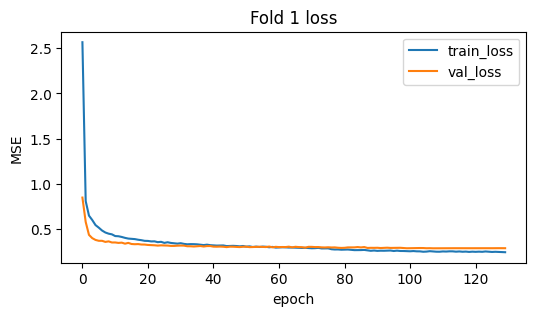


--- Fold 2/5 ---
Epoch 1/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8675 - mse: 3.8675

207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 3.8607 - mse: 3.8607 - val_loss: 0.8990 - val_mse: 0.8990 - learning_rate: 0.0010
Epoch 2/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8764 - mse: 0.8764

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8737 - mse: 0.8737 - val_loss: 0.6315 - val_mse: 0.6315 - learning_rate: 0.0010
Epoch 3/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6993 - mse: 0.6993

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6974 - mse: 0.6974 - val_loss: 0.4994 - val_mse: 0.4994 - learning_rate: 0.0010
Epoch 4/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6052 - mse: 0.6052

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6048 - mse: 0.6048 - val_loss: 0.4591 - val_mse: 0.4591 - learning_rate: 0.0010
Epoch 5/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5438 - mse: 0.5438

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5443 - mse: 0.5443 - val_loss: 0.4300 - val_mse: 0.4300 - learning_rate: 0.0010
Epoch 6/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5169 - mse: 0.5169

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5168 - mse: 0.5168 - val_loss: 0.4196 - val_mse: 0.4196 - learning_rate: 0.0010
Epoch 7/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5032 - mse: 0.5032

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5027 - mse: 0.5027 - val_loss: 0.4061 - val_mse: 0.4061 - learning_rate: 0.0010
Epoch 8/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4600 - mse: 0.4600 - val_loss: 0.4114 - val_mse: 0.4114 - learning_rate: 0.0010
Epoch 9/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4531 - mse: 0.4531

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4530 - mse: 0.4530 - val_loss: 0.3875 - val_mse: 0.3875 - learning_rate: 0.0010
Epoch 10/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4319 - mse: 0.4319

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4322 - mse: 0.4322 - val_loss: 0.3696 - val_mse: 0.3696 - learning_rate: 0.0010
Epoch 11/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4202 - mse: 0.4202 - val_loss: 0.3704 - val_mse: 0.3704 - learning_rate: 0.0010
Epoch 12/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4088 - mse: 0.4088

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4092 - mse: 0.4092 - val_loss: 0.3696 - val_mse: 0.3696 - learning_rate: 0.0010
Epoch 13/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3951 - mse: 0.3951

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3954 - mse: 0.3954 - val_loss: 0.3644 - val_mse: 0.3644 - learning_rate: 0.0010
Epoch 14/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3897 - mse: 0.3897

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3900 - mse: 0.3900 - val_loss: 0.3583 - val_mse: 0.3583 - learning_rate: 0.0010
Epoch 15/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3838 - mse: 0.3838 - val_loss: 0.3592 - val_mse: 0.3592 - learning_rate: 0.0010
Epoch 16/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3745 - mse: 0.3745

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3751 - mse: 0.3751 - val_loss: 0.3499 - val_mse: 0.3499 - learning_rate: 0.0010
Epoch 17/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3715 - mse: 0.3715

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3717 - mse: 0.3717 - val_loss: 0.3470 - val_mse: 0.3470 - learning_rate: 0.0010
Epoch 18/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3721 - mse: 0.3721

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3723 - mse: 0.3723 - val_loss: 0.3419 - val_mse: 0.3419 - learning_rate: 0.0010
Epoch 19/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3687 - mse: 0.3687

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3689 - mse: 0.3689 - val_loss: 0.3381 - val_mse: 0.3381 - learning_rate: 0.0010
Epoch 20/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3670 - mse: 0.3670 - val_loss: 0.3482 - val_mse: 0.3482 - learning_rate: 0.0010
Epoch 21/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3581 - mse: 0.3581

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3585 - mse: 0.3585 - val_loss: 0.3356 - val_mse: 0.3356 - learning_rate: 0.0010
Epoch 22/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3535 - mse: 0.3535 - val_loss: 0.3508 - val_mse: 0.3508 - learning_rate: 0.0010
Epoch 23/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3518 - mse: 0.3518 - val_loss: 0.3438 - val_mse: 0.3438 - learning_rate: 0.0010
Epoch 24/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3486 - mse: 0.3486 - val_loss: 0.3370 - val_mse: 0.3370 - learning_rate: 0.0010
Epoch 25/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3467 - mse: 0.3467 - val_loss: 0.3359 - val_mse: 0.3359 - learning_rate: 0.0010
Epoch 26/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3359 - mse: 0.3359

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3363 - mse: 0.3363 - val_loss: 0.3294 - val_mse: 0.3294 - learning_rate: 0.0010
Epoch 27/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3367 - mse: 0.3367 - val_loss: 0.3315 - val_mse: 0.3315 - learning_rate: 0.0010
Epoch 28/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3326 - mse: 0.3326 - val_loss: 0.3302 - val_mse: 0.3302 - learning_rate: 0.0010
Epoch 29/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3355 - mse: 0.3355 - val_loss: 0.3406 - val_mse: 0.3406 - learning_rate: 0.0010
Epoch 30/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3346 - mse: 0.3346 - val_loss: 0.3388 - val_mse: 0.3388 - learning_rate: 0.0010
Epoch 31/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3308 - mse: 0.3308 - val_loss: 0.3340 - val_mse: 0.3340 - learning_rate: 0.0010
Epoch 32/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3247 - mse: 0.3247 - val_loss: 0.3348 - val_mse: 0.3348 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3296 - mse: 0.3296 - val_loss: 0.3233 - val_mse: 0.3233 - learning_rate: 0.0010
Epoch 34/200
204/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3229 - mse: 0.3229

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3230 - mse: 0.3230 - val_loss: 0.3231 - val_mse: 0.3231 - learning_rate: 0.0010
Epoch 35/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3229 - mse: 0.3229 - val_loss: 0.3306 - val_mse: 0.3306 - learning_rate: 0.0010
Epoch 36/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3224 - mse: 0.3224 - val_loss: 0.3303 - val_mse: 0.3303 - learning_rate: 0.0010
Epoch 37/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3206 - mse: 0.3206 - val_loss: 0.3271 - val_mse: 0.3271 - learning_rate: 0.0010
Epoch 38/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3213 - mse: 0.3213 - val_loss: 0.3255 - val_mse: 0.3255 - learning_rate: 0.0010
Epoch 39/200
204/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3194 - mse: 0.3194

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3195 - mse: 0.3195 - val_loss: 0.3207 - val_mse: 0.3207 - learning_rate: 0.0010
Epoch 40/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3117 - mse: 0.3117 - val_loss: 0.3271 - val_mse: 0.3271 - learning_rate: 0.0010
Epoch 41/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3154 - mse: 0.3154 - val_loss: 0.3265 - val_mse: 0.3265 - learning_rate: 0.0010
Epoch 42/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3184 - mse: 0.3184 - val_loss: 0.3223 - val_mse: 0.3223 - learning_rate: 0.0010
Epoch 43/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3118 - mse: 0.3118 - val_loss: 0.3230 - val_mse: 0.3230 - learning_rate: 0.0010
Epoch 44/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3121 - mse: 0.3121

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3124 - mse: 0.3124 - val_loss: 0.3193 - val_mse: 0.3193 - learning_rate: 0.0010
Epoch 45/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3082 - mse: 0.3082 - val_loss: 0.3207 - val_mse: 0.3207 - learning_rate: 0.0010
Epoch 46/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3068 - mse: 0.3068 - val_loss: 0.3210 - val_mse: 0.3210 - learning_rate: 0.0010
Epoch 47/200
202/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3064 - mse: 0.3064

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3066 - mse: 0.3066 - val_loss: 0.3186 - val_mse: 0.3186 - learning_rate: 0.0010
Epoch 48/200
186/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3058 - mse: 0.3058

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3064 - mse: 0.3064 - val_loss: 0.3140 - val_mse: 0.3140 - learning_rate: 0.0010
Epoch 49/200
186/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3015 - mse: 0.3015

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3020 - mse: 0.3020 - val_loss: 0.3124 - val_mse: 0.3124 - learning_rate: 0.0010
Epoch 50/200
186/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3016 - mse: 0.3016

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3022 - mse: 0.3022 - val_loss: 0.3113 - val_mse: 0.3113 - learning_rate: 0.0010
Epoch 51/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3078 - mse: 0.3078 - val_loss: 0.3139 - val_mse: 0.3139 - learning_rate: 0.0010
Epoch 52/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3032 - mse: 0.3032 - val_loss: 0.3191 - val_mse: 0.3191 - learning_rate: 0.0010
Epoch 53/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3012 - mse: 0.3012 - val_loss: 0.3202 - val_mse: 0.3202 - learning_rate: 0.0010
Epoch 54/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3053 - mse: 0.3053 - val_loss: 0.3206 - val_mse: 0.3206 - learning_rate: 0.0010
Epoch 55/200
204/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3000 - mse: 0.3000

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3001 - mse: 0.3001 - val_loss: 0.3111 - val_mse: 0.3111 - learning_rate: 0.0010
Epoch 56/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2987 - mse: 0.2987 - val_loss: 0.3170 - val_mse: 0.3170 - learning_rate: 0.0010
Epoch 57/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2924 - mse: 0.2924 - val_loss: 0.3203 - val_mse: 0.3203 - learning_rate: 0.0010
Epoch 58/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2999 - mse: 0.2999 - val_loss: 0.3121 - val_mse: 0.3121 - learning_rate: 0.0010
Epoch 59/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3017 - mse: 0.3017 - val_loss: 0.3115 - val_mse: 0.3115 - learning_rate: 0.0010
Epoch 60/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2932 - mse: 0.2932 - val_loss: 0.3173 - val_mse: 0.3173 - learning_rate: 0.0010
Epoch 61/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2933 - mse: 0.2933

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2938 - mse: 0.2938 - val_loss: 0.3109 - val_mse: 0.3109 - learning_rate: 0.0010
Epoch 62/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2994 - mse: 0.2994

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2996 - mse: 0.2996 - val_loss: 0.3080 - val_mse: 0.3080 - learning_rate: 0.0010
Epoch 63/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2868 - mse: 0.2868 - val_loss: 0.3109 - val_mse: 0.3109 - learning_rate: 0.0010
Epoch 64/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2939 - mse: 0.2939 - val_loss: 0.3174 - val_mse: 0.3174 - learning_rate: 0.0010
Epoch 65/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2937 - mse: 0.2937 - val_loss: 0.3150 - val_mse: 0.3150 - learning_rate: 0.0010
Epoch 66/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2934 - mse: 0.2934 - val_loss: 0.3087 - val_mse: 0.3087 - learning_rate: 0.0010
Epoch 67/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2915 - mse: 0.2915 - val_loss: 0.3108 - val_mse: 0.3108 - learning_rate: 0.0010
Epoch 68/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2895 - mse: 0.2895 - val_loss: 0.3111 - val_mse: 0.3111 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2919 - mse: 0.2919 - val_loss: 0.3077 - val_mse: 0.3077 - learning_rate: 0.0010
Epoch 70/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2861 - mse: 0.2861 - val_loss: 0.3120 - val_mse: 0.3120 - learning_rate: 0.0010
Epoch 71/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2909 - mse: 0.2909 - val_loss: 0.3108 - val_mse: 0.3108 - learning_rate: 0.0010
Epoch 72/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2884 - mse: 0.2884 - val_loss: 0.3141 - val_mse: 0.3141 - learning_rate: 0.0010
Epoch 73/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2893 - mse: 0.2893

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2896 - mse: 0.2896 - val_loss: 0.3048 - val_mse: 0.3048 - learning_rate: 0.0010
Epoch 74/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2852 - mse: 0.2852 - val_loss: 0.3079 - val_mse: 0.3079 - learning_rate: 0.0010
Epoch 75/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2858 - mse: 0.2858 - val_loss: 0.3086 - val_mse: 0.3086 - learning_rate: 0.0010
Epoch 76/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2861 - mse: 0.2861 - val_loss: 0.3122 - val_mse: 0.3122 - learning_rate: 0.0010
Epoch 77/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2847 - mse: 0.2847 - val_loss: 0.3092 - val_mse: 0.3092 - learning_rate: 0.0010
Epoch 78/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2864 - mse: 0.2864 - val_loss: 0.3147 - val_mse: 0.3147 - learning_rate: 0.0010
Epoch 79/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2799 - mse: 0.2799 - val_loss: 0.3075 - val_mse: 0.3075 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2758 - mse: 0.2758 - val_loss: 0.3048 - val_mse: 0.3048 - learning_rate: 5.0000e-04
Epoch 82/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2719 - mse: 0.2719 - val_loss: 0.3050 - val_mse: 0.3050 - learning_rate: 5.0000e-04
Epoch 83/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2682 - mse: 0.2682 - val_loss: 0.3049 - val_mse: 0.3049 - learning_rate: 5.0000e-04
Epoch 84/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2710 - mse: 0.2710 - val_loss: 0.3054 - val_mse: 0.3054 - learning_rate: 5.0000e-04
Epoch 85/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2634 - mse: 0.2634

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2641 - mse: 0.2641 - val_loss: 0.3030 - val_mse: 0.3030 - learning_rate: 5.0000e-04
Epoch 86/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2665 - mse: 0.2665 - val_loss: 0.3097 - val_mse: 0.3097 - learning_rate: 5.0000e-04
Epoch 87/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2703 - mse: 0.2703

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2705 - mse: 0.2705 - val_loss: 0.3016 - val_mse: 0.3016 - learning_rate: 5.0000e-04
Epoch 88/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2605 - mse: 0.2605 - val_loss: 0.3063 - val_mse: 0.3063 - learning_rate: 5.0000e-04
Epoch 89/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2661 - mse: 0.2661 - val_loss: 0.3039 - val_mse: 0.3039 - learning_rate: 5.0000e-04
Epoch 90/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2662 - mse: 0.2662 - val_loss: 0.3039 - val_mse: 0.3039 - learning_rate: 5.0000e-04
Epoch 91/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2664 - mse: 0.2664 - val_loss: 0.3066 - val_mse: 0.3066 - learning_rate: 5.0000e-04
Epoch 92/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2703 - mse: 0.2703 - val_loss: 0.3051 - val_mse: 0.3051 - learning_rate: 5.0000e-04
Epoch 93/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2640 - mse: 0.2640 - val_loss: 0.3034 - val_mse: 0.3034 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2570 - mse: 0.2570 - val_loss: 0.3013 - val_mse: 0.3013 - learning_rate: 2.5000e-04
Epoch 98/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2570 - mse: 0.2570

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2575 - mse: 0.2575 - val_loss: 0.2988 - val_mse: 0.2988 - learning_rate: 2.5000e-04
Epoch 99/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2530 - mse: 0.2530 - val_loss: 0.3006 - val_mse: 0.3006 - learning_rate: 2.5000e-04
Epoch 100/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2586 - mse: 0.2586 - val_loss: 0.3021 - val_mse: 0.3021 - learning_rate: 2.5000e-04
Epoch 101/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2508 - mse: 0.2508 - val_loss: 0.2998 - val_mse: 0.2998 - learning_rate: 2.5000e-04
Epoch 102/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2568 - mse: 0.2568 - val_loss: 0.3006 - val_mse: 0.3006 - learning_rate: 2.5000e-04
Epoch 103/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2556 - mse: 0.2556 - val_loss: 0.3013 - val_mse: 0.3013 - learning_rate: 2.5000e-04
Epoch 104/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2514 - mse: 0.2514 - val_loss: 0.2991 - val_mse: 0.2991 

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2555 - mse: 0.2555 - val_loss: 0.2983 - val_mse: 0.2983 - learning_rate: 1.2500e-04
Epoch 108/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2485 - mse: 0.2485 - val_loss: 0.2985 - val_mse: 0.2985 - learning_rate: 1.2500e-04
Epoch 109/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2531 - mse: 0.2531 - val_loss: 0.2984 - val_mse: 0.2984 - learning_rate: 1.2500e-04
Epoch 110/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2498 - mse: 0.2498 - val_loss: 0.2996 - val_mse: 0.2996 - learning_rate: 1.2500e-04
Epoch 111/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2514 - mse: 0.2514 - val_loss: 0.2987 - val_mse: 0.2987 - learning_rate: 1.2500e-04
Epoch 112/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2531 - mse: 0.2531 - val_loss: 0.2991 - val_mse: 0.2991 - learning_rate: 1.2500e-04
Epoch 113/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2498 - mse: 0.2498

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2499 - mse: 0.2499 - val_loss: 0.2982 - val_mse: 0.2982 - learning_rate: 1.2500e-04
Epoch 114/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2513 - mse: 0.2513 - val_loss: 0.2988 - val_mse: 0.2988 - learning_rate: 1.2500e-04
Epoch 115/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2506 - mse: 0.2506

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2509 - mse: 0.2509 - val_loss: 0.2972 - val_mse: 0.2972 - learning_rate: 1.2500e-04
Epoch 116/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2498 - mse: 0.2498 - val_loss: 0.2977 - val_mse: 0.2977 - learning_rate: 1.2500e-04
Epoch 117/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2499 - mse: 0.2499 - val_loss: 0.2975 - val_mse: 0.2975 - learning_rate: 1.2500e-04
Epoch 118/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2492 - mse: 0.2492 - val_loss: 0.2983 - val_mse: 0.2983 - learning_rate: 1.2500e-04
Epoch 119/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2553 - mse: 0.2553 - val_loss: 0.2996 - val_mse: 0.2996 - learning_rate: 1.2500e-04
Epoch 120/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2472 - mse: 0.2472 - val_loss: 0.2984 - val_mse: 0.2984 - learning_rate: 1.2500e-04
Epoch 121/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2490 - mse: 0.2490 - val_loss: 0.2995 - val_mse: 0.2995

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2542 - mse: 0.2542 - val_loss: 0.2970 - val_mse: 0.2970 - learning_rate: 6.2500e-05
Epoch 130/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2466 - mse: 0.2466 - val_loss: 0.2979 - val_mse: 0.2979 - learning_rate: 6.2500e-05
Epoch 131/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2462 - mse: 0.2462 - val_loss: 0.2982 - val_mse: 0.2982 - learning_rate: 6.2500e-05
Epoch 132/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2468 - mse: 0.2468 - val_loss: 0.2977 - val_mse: 0.2977 - learning_rate: 6.2500e-05
Epoch 133/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2479 - mse: 0.2479 - val_loss: 0.2982 - val_mse: 0.2982 - learning_rate: 6.2500e-05
Epoch 134/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2487 - mse: 0.2487 - val_loss: 0.2984 - val_mse: 0.2984 - learning_rate: 6.2500e-05
Epoch 135/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2475 - mse: 0.2475 - val_loss: 0.2990 - val_mse: 0.2990

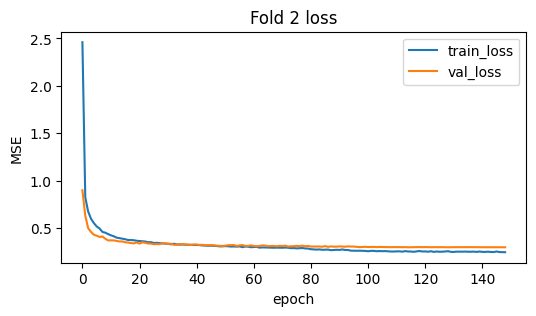


--- Fold 3/5 ---
Epoch 1/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1714 - mse: 4.1714

207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 4.1638 - mse: 4.1638 - val_loss: 0.8519 - val_mse: 0.8519 - learning_rate: 0.0010
Epoch 2/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9176 - mse: 0.9176

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9145 - mse: 0.9145 - val_loss: 0.5734 - val_mse: 0.5734 - learning_rate: 0.0010
Epoch 3/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7429 - mse: 0.7429

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7423 - mse: 0.7423 - val_loss: 0.4877 - val_mse: 0.4877 - learning_rate: 0.0010
Epoch 4/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6655 - mse: 0.6655

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6644 - mse: 0.6644 - val_loss: 0.4163 - val_mse: 0.4163 - learning_rate: 0.0010
Epoch 5/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6075 - mse: 0.6075

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6064 - mse: 0.6064 - val_loss: 0.4069 - val_mse: 0.4069 - learning_rate: 0.0010
Epoch 6/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5474 - mse: 0.5474

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5472 - mse: 0.5472 - val_loss: 0.3823 - val_mse: 0.3823 - learning_rate: 0.0010
Epoch 7/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5103 - mse: 0.5103 - val_loss: 0.3825 - val_mse: 0.3825 - learning_rate: 0.0010
Epoch 8/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5004 - mse: 0.5004

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5000 - mse: 0.5000 - val_loss: 0.3690 - val_mse: 0.3690 - learning_rate: 0.0010
Epoch 9/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4807 - mse: 0.4807

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4794 - mse: 0.4794 - val_loss: 0.3438 - val_mse: 0.3438 - learning_rate: 0.0010
Epoch 10/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4437 - mse: 0.4437 - val_loss: 0.3456 - val_mse: 0.3456 - learning_rate: 0.0010
Epoch 11/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4328 - mse: 0.4328

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4328 - mse: 0.4328 - val_loss: 0.3393 - val_mse: 0.3393 - learning_rate: 0.0010
Epoch 12/200
205/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4238 - mse: 0.4238

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4238 - mse: 0.4238 - val_loss: 0.3323 - val_mse: 0.3323 - learning_rate: 0.0010
Epoch 13/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4088 - mse: 0.4088 - val_loss: 0.3340 - val_mse: 0.3340 - learning_rate: 0.0010
Epoch 14/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4065 - mse: 0.4065

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4065 - mse: 0.4065 - val_loss: 0.3309 - val_mse: 0.3309 - learning_rate: 0.0010
Epoch 15/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3934 - mse: 0.3934

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3934 - mse: 0.3934 - val_loss: 0.3266 - val_mse: 0.3266 - learning_rate: 0.0010
Epoch 16/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3909 - mse: 0.3909 - val_loss: 0.3276 - val_mse: 0.3276 - learning_rate: 0.0010
Epoch 17/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3847 - mse: 0.3847

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3846 - mse: 0.3846 - val_loss: 0.3196 - val_mse: 0.3196 - learning_rate: 0.0010
Epoch 18/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3793 - mse: 0.3793

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3795 - mse: 0.3795 - val_loss: 0.3148 - val_mse: 0.3148 - learning_rate: 0.0010
Epoch 19/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3726 - mse: 0.3726 - val_loss: 0.3180 - val_mse: 0.3180 - learning_rate: 0.0010
Epoch 20/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3721 - mse: 0.3721

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3721 - mse: 0.3721 - val_loss: 0.3130 - val_mse: 0.3130 - learning_rate: 0.0010
Epoch 21/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3596 - mse: 0.3596 - val_loss: 0.3193 - val_mse: 0.3193 - learning_rate: 0.0010
Epoch 22/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3661 - mse: 0.3661

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3660 - mse: 0.3660 - val_loss: 0.3099 - val_mse: 0.3099 - learning_rate: 0.0010
Epoch 23/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3562 - mse: 0.3562

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3563 - mse: 0.3563 - val_loss: 0.3031 - val_mse: 0.3031 - learning_rate: 0.0010
Epoch 24/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3540 - mse: 0.3540

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3541 - mse: 0.3541 - val_loss: 0.3008 - val_mse: 0.3008 - learning_rate: 0.0010
Epoch 25/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3556 - mse: 0.3556 - val_loss: 0.3012 - val_mse: 0.3012 - learning_rate: 0.0010
Epoch 26/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3442 - mse: 0.3442 - val_loss: 0.3090 - val_mse: 0.3090 - learning_rate: 0.0010
Epoch 27/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3454 - mse: 0.3454

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3456 - mse: 0.3456 - val_loss: 0.2998 - val_mse: 0.2998 - learning_rate: 0.0010
Epoch 28/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3418 - mse: 0.3418 - val_loss: 0.3023 - val_mse: 0.3023 - learning_rate: 0.0010
Epoch 29/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3404 - mse: 0.3404

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3405 - mse: 0.3405 - val_loss: 0.2988 - val_mse: 0.2988 - learning_rate: 0.0010
Epoch 30/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3423 - mse: 0.3423 - val_loss: 0.3029 - val_mse: 0.3029 - learning_rate: 0.0010
Epoch 31/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3353 - mse: 0.3353

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3356 - mse: 0.3356 - val_loss: 0.2981 - val_mse: 0.2981 - learning_rate: 0.0010
Epoch 32/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3310 - mse: 0.3310

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3313 - mse: 0.3313 - val_loss: 0.2981 - val_mse: 0.2981 - learning_rate: 0.0010
Epoch 33/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3340 - mse: 0.3340 - val_loss: 0.3038 - val_mse: 0.3038 - learning_rate: 0.0010
Epoch 34/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3376 - mse: 0.3376

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3375 - mse: 0.3375 - val_loss: 0.2980 - val_mse: 0.2980 - learning_rate: 0.0010
Epoch 35/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3337 - mse: 0.3337

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3339 - mse: 0.3339 - val_loss: 0.2941 - val_mse: 0.2941 - learning_rate: 0.0010
Epoch 36/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3307 - mse: 0.3307 - val_loss: 0.2950 - val_mse: 0.2950 - learning_rate: 0.0010
Epoch 37/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3289 - mse: 0.3289

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3290 - mse: 0.3290 - val_loss: 0.2926 - val_mse: 0.2926 - learning_rate: 0.0010
Epoch 38/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3256 - mse: 0.3256 - val_loss: 0.2941 - val_mse: 0.2941 - learning_rate: 0.0010
Epoch 39/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3250 - mse: 0.3250 - val_loss: 0.2971 - val_mse: 0.2971 - learning_rate: 0.0010
Epoch 40/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3281 - mse: 0.3281 - val_loss: 0.2936 - val_mse: 0.2936 - learning_rate: 0.0010
Epoch 41/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3218 - mse: 0.3218

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3217 - mse: 0.3217 - val_loss: 0.2916 - val_mse: 0.2916 - learning_rate: 0.0010
Epoch 42/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3253 - mse: 0.3253 - val_loss: 0.2938 - val_mse: 0.2938 - learning_rate: 0.0010
Epoch 43/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3202 - mse: 0.3202 - val_loss: 0.2923 - val_mse: 0.2923 - learning_rate: 0.0010
Epoch 44/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3191 - mse: 0.3191 - val_loss: 0.2920 - val_mse: 0.2920 - learning_rate: 0.0010
Epoch 45/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3202 - mse: 0.3202 - val_loss: 0.2966 - val_mse: 0.2966 - learning_rate: 0.0010
Epoch 46/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3170 - mse: 0.3170 - val_loss: 0.2928 - val_mse: 0.2928 - learning_rate: 0.0010
Epoch 47/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3153 - mse: 0.3153 - val_loss: 0.3011 - val_mse: 0.3011 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3077 - mse: 0.3077 - val_loss: 0.2901 - val_mse: 0.2901 - learning_rate: 5.0000e-04
Epoch 50/200
186/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3088 - mse: 0.3088

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3083 - mse: 0.3083 - val_loss: 0.2879 - val_mse: 0.2879 - learning_rate: 5.0000e-04
Epoch 51/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3041 - mse: 0.3041 - val_loss: 0.2896 - val_mse: 0.2896 - learning_rate: 5.0000e-04
Epoch 52/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3021 - mse: 0.3021 - val_loss: 0.2884 - val_mse: 0.2884 - learning_rate: 5.0000e-04
Epoch 53/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2982 - mse: 0.2982

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2981 - mse: 0.2981 - val_loss: 0.2852 - val_mse: 0.2852 - learning_rate: 5.0000e-04
Epoch 54/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3000 - mse: 0.3000 - val_loss: 0.2890 - val_mse: 0.2890 - learning_rate: 5.0000e-04
Epoch 55/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3009 - mse: 0.3009 - val_loss: 0.2888 - val_mse: 0.2888 - learning_rate: 5.0000e-04
Epoch 56/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3000 - mse: 0.3000 - val_loss: 0.2875 - val_mse: 0.2875 - learning_rate: 5.0000e-04
Epoch 57/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3018 - mse: 0.3018

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3015 - mse: 0.3015 - val_loss: 0.2821 - val_mse: 0.2821 - learning_rate: 5.0000e-04
Epoch 58/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2960 - mse: 0.2960 - val_loss: 0.2881 - val_mse: 0.2881 - learning_rate: 5.0000e-04
Epoch 59/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2994 - mse: 0.2994 - val_loss: 0.2885 - val_mse: 0.2885 - learning_rate: 5.0000e-04
Epoch 60/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2918 - mse: 0.2918 - val_loss: 0.2863 - val_mse: 0.2863 - learning_rate: 5.0000e-04
Epoch 61/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2960 - mse: 0.2960 - val_loss: 0.2849 - val_mse: 0.2849 - learning_rate: 5.0000e-04
Epoch 62/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2973 - mse: 0.2973 - val_loss: 0.2867 - val_mse: 0.2867 - learning_rate: 5.0000e-04
Epoch 63/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2957 - mse: 0.2957 - val_loss: 0.2839 - val_mse: 0.2839 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2866 - mse: 0.2866 - val_loss: 0.2821 - val_mse: 0.2821 - learning_rate: 2.5000e-04
Epoch 68/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2899 - mse: 0.2899 - val_loss: 0.2828 - val_mse: 0.2828 - learning_rate: 2.5000e-04
Epoch 69/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2846 - mse: 0.2846 - val_loss: 0.2838 - val_mse: 0.2838 - learning_rate: 2.5000e-04
Epoch 70/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2860 - mse: 0.2860 - val_loss: 0.2878 - val_mse: 0.2878 - learning_rate: 2.5000e-04
Epoch 71/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2900 - mse: 0.2900
Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2895 - mse: 0.2895 - val_loss: 0.2873 - val_mse: 0.2873 - learning_rate: 2.5000e-04
Epoch 72/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2879 - mse: 0.2879

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2870 - mse: 0.2870 - val_loss: 0.2803 - val_mse: 0.2803 - learning_rate: 1.2500e-04
Epoch 73/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2886 - mse: 0.2886 - val_loss: 0.2812 - val_mse: 0.2812 - learning_rate: 1.2500e-04
Epoch 74/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2806 - mse: 0.2806 - val_loss: 0.2811 - val_mse: 0.2811 - learning_rate: 1.2500e-04
Epoch 75/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2852 - mse: 0.2852 - val_loss: 0.2821 - val_mse: 0.2821 - learning_rate: 1.2500e-04
Epoch 76/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2781 - mse: 0.2781 - val_loss: 0.2822 - val_mse: 0.2822 - learning_rate: 1.2500e-04
Epoch 77/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2823 - mse: 0.2823 - val_loss: 0.2806 - val_mse: 0.2806 - learning_rate: 1.2500e-04
Epoch 78/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2810 - mse: 0.2810 - val_loss: 0.2814 - val_mse: 0.2814 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2790 - mse: 0.2790 - val_loss: 0.2791 - val_mse: 0.2791 - learning_rate: 6.2500e-05
Epoch 81/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2800 - mse: 0.2800

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2798 - mse: 0.2798 - val_loss: 0.2790 - val_mse: 0.2790 - learning_rate: 6.2500e-05
Epoch 82/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2750 - mse: 0.2750

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2748 - mse: 0.2748 - val_loss: 0.2786 - val_mse: 0.2786 - learning_rate: 6.2500e-05
Epoch 83/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2798 - mse: 0.2798 - val_loss: 0.2787 - val_mse: 0.2787 - learning_rate: 6.2500e-05
Epoch 84/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2737 - mse: 0.2737 - val_loss: 0.2786 - val_mse: 0.2786 - learning_rate: 6.2500e-05
Epoch 85/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2819 - mse: 0.2819

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2815 - mse: 0.2815 - val_loss: 0.2782 - val_mse: 0.2782 - learning_rate: 6.2500e-05
Epoch 86/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2779 - mse: 0.2779

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2777 - mse: 0.2777 - val_loss: 0.2781 - val_mse: 0.2781 - learning_rate: 6.2500e-05
Epoch 87/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2781 - mse: 0.2781

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2777 - mse: 0.2777 - val_loss: 0.2777 - val_mse: 0.2777 - learning_rate: 6.2500e-05
Epoch 88/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2742 - mse: 0.2742 - val_loss: 0.2788 - val_mse: 0.2788 - learning_rate: 6.2500e-05
Epoch 89/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2798 - mse: 0.2798 - val_loss: 0.2778 - val_mse: 0.2778 - learning_rate: 6.2500e-05
Epoch 90/200
196/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2705 - mse: 0.2705

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2706 - mse: 0.2706 - val_loss: 0.2776 - val_mse: 0.2776 - learning_rate: 6.2500e-05
Epoch 91/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2740 - mse: 0.2740

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2740 - mse: 0.2740 - val_loss: 0.2774 - val_mse: 0.2774 - learning_rate: 6.2500e-05
Epoch 92/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2680 - mse: 0.2680 - val_loss: 0.2775 - val_mse: 0.2775 - learning_rate: 6.2500e-05
Epoch 93/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2752 - mse: 0.2752 - val_loss: 0.2777 - val_mse: 0.2777 - learning_rate: 6.2500e-05
Epoch 94/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2790 - mse: 0.2790 - val_loss: 0.2776 - val_mse: 0.2776 - learning_rate: 6.2500e-05
Epoch 95/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2769 - mse: 0.2769 - val_loss: 0.2778 - val_mse: 0.2778 - learning_rate: 6.2500e-05
Epoch 96/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2759 - mse: 0.2759 - val_loss: 0.2777 - val_mse: 0.2777 - learning_rate: 6.2500e-05
Epoch 97/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2743 - mse: 0.2743 - val_loss: 0.2781 - val_mse: 0.2781 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2781 - mse: 0.2781 - val_loss: 0.2773 - val_mse: 0.2773 - learning_rate: 3.1250e-05
Epoch 100/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2750 - mse: 0.2750

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2748 - mse: 0.2748 - val_loss: 0.2769 - val_mse: 0.2769 - learning_rate: 3.1250e-05
Epoch 101/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2771 - mse: 0.2771

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2766 - mse: 0.2766 - val_loss: 0.2769 - val_mse: 0.2769 - learning_rate: 3.1250e-05
Epoch 102/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2735 - mse: 0.2735 - val_loss: 0.2773 - val_mse: 0.2773 - learning_rate: 3.1250e-05
Epoch 103/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2767 - mse: 0.2767

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2766 - mse: 0.2766 - val_loss: 0.2768 - val_mse: 0.2768 - learning_rate: 3.1250e-05
Epoch 104/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2747 - mse: 0.2747 - val_loss: 0.2770 - val_mse: 0.2770 - learning_rate: 3.1250e-05
Epoch 105/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2715 - mse: 0.2715 - val_loss: 0.2769 - val_mse: 0.2769 - learning_rate: 3.1250e-05
Epoch 106/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2764 - mse: 0.2764 - val_loss: 0.2774 - val_mse: 0.2774 - learning_rate: 3.1250e-05
Epoch 107/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2732 - mse: 0.2732 - val_loss: 0.2773 - val_mse: 0.2773 - learning_rate: 3.1250e-05
Epoch 108/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2712 - mse: 0.2712 - val_loss: 0.2774 - val_mse: 0.2774 - learning_rate: 3.1250e-05
Epoch 109/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2750 - mse: 0.2750 - val_loss: 0.2773 - val_mse: 0.2773

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2707 - mse: 0.2707 - val_loss: 0.2768 - val_mse: 0.2768 - learning_rate: 3.1250e-05
Epoch 111/200
198/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2712 - mse: 0.2712

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2710 - mse: 0.2710 - val_loss: 0.2768 - val_mse: 0.2768 - learning_rate: 1.5625e-05
Epoch 112/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2756 - mse: 0.2756

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2754 - mse: 0.2754 - val_loss: 0.2767 - val_mse: 0.2767 - learning_rate: 1.5625e-05
Epoch 113/200
198/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2718 - mse: 0.2718

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2717 - mse: 0.2717 - val_loss: 0.2765 - val_mse: 0.2765 - learning_rate: 1.5625e-05
Epoch 114/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2690 - mse: 0.2690 - val_loss: 0.2767 - val_mse: 0.2767 - learning_rate: 1.5625e-05
Epoch 115/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2717 - mse: 0.2717 - val_loss: 0.2769 - val_mse: 0.2769 - learning_rate: 1.5625e-05
Epoch 116/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2742 - mse: 0.2742 - val_loss: 0.2768 - val_mse: 0.2768 - learning_rate: 1.5625e-05
Epoch 117/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2731 - mse: 0.2731 - val_loss: 0.2768 - val_mse: 0.2768 - learning_rate: 1.5625e-05
Epoch 118/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2723 - mse: 0.2723 - val_loss: 0.2768 - val_mse: 0.2768 - learning_rate: 1.5625e-05
Epoch 119/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2774 - mse: 0.2774

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2771 - mse: 0.2771 - val_loss: 0.2764 - val_mse: 0.2764 - learning_rate: 1.5625e-05
Epoch 120/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2699 - mse: 0.2699
Epoch 120: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2698 - mse: 0.2698 - val_loss: 0.2768 - val_mse: 0.2768 - learning_rate: 1.5625e-05
Epoch 121/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2684 - mse: 0.2684 - val_loss: 0.2766 - val_mse: 0.2766 - learning_rate: 7.8125e-06
Epoch 122/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2731 - mse: 0.2731 - val_loss: 0.2766 - val_mse: 0.2766 - learning_rate: 7.8125e-06
Epoch 123/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2774 - mse: 0.2774 - val_loss: 0.2766 - val_mse: 0.2766 - learning_rate: 7.8125e-06
Epoch 124/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2703 - mse: 0.2703 - val_loss: 0.2768 - val_mse: 0.2768 

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2717 - mse: 0.2717 - val_loss: 0.2764 - val_mse: 0.2764 - learning_rate: 1.9531e-06
Epoch 138/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2710 - mse: 0.2710 - val_loss: 0.2766 - val_mse: 0.2766 - learning_rate: 1.9531e-06
Epoch 139/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2717 - mse: 0.2717 - val_loss: 0.2767 - val_mse: 0.2767 - learning_rate: 1.9531e-06
Epoch 140/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2733 - mse: 0.2733 - val_loss: 0.2765 - val_mse: 0.2765 - learning_rate: 1.9531e-06
Epoch 141/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2676 - mse: 0.2676 - val_loss: 0.2765 - val_mse: 0.2765 - learning_rate: 1.9531e-06
Epoch 142/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2740 - mse: 0.2740 - val_loss: 0.2765 - val_mse: 0.2765 - learning_rate: 1.9531e-06
Epoch 143/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2679 - mse: 0.2679 - val_loss: 0.2765 - val_mse: 0.2765

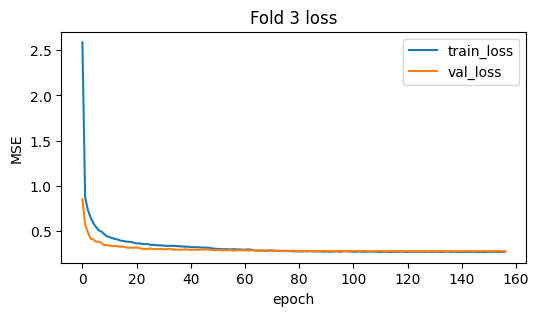


--- Fold 4/5 ---
Epoch 1/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0316 - mse: 4.0316

207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 4.0245 - mse: 4.0245 - val_loss: 1.0141 - val_mse: 1.0141 - learning_rate: 0.0010
Epoch 2/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9182 - mse: 0.9182

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9133 - mse: 0.9133 - val_loss: 0.6229 - val_mse: 0.6229 - learning_rate: 0.0010
Epoch 3/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7341 - mse: 0.7341

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7333 - mse: 0.7333 - val_loss: 0.4956 - val_mse: 0.4956 - learning_rate: 0.0010
Epoch 4/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6509 - mse: 0.6509

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6509 - mse: 0.6509 - val_loss: 0.4497 - val_mse: 0.4497 - learning_rate: 0.0010
Epoch 5/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5826 - mse: 0.5826

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5831 - mse: 0.5831 - val_loss: 0.4230 - val_mse: 0.4230 - learning_rate: 0.0010
Epoch 6/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5407 - mse: 0.5407 - val_loss: 0.4266 - val_mse: 0.4266 - learning_rate: 0.0010
Epoch 7/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4958 - mse: 0.4958

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4963 - mse: 0.4963 - val_loss: 0.4054 - val_mse: 0.4054 - learning_rate: 0.0010
Epoch 8/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4650 - mse: 0.4650

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4657 - mse: 0.4657 - val_loss: 0.3870 - val_mse: 0.3870 - learning_rate: 0.0010
Epoch 9/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4559 - mse: 0.4559

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4568 - mse: 0.4568 - val_loss: 0.3732 - val_mse: 0.3732 - learning_rate: 0.0010
Epoch 10/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4476 - mse: 0.4476

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4476 - mse: 0.4476 - val_loss: 0.3640 - val_mse: 0.3640 - learning_rate: 0.0010
Epoch 11/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4222 - mse: 0.4222 - val_loss: 0.3683 - val_mse: 0.3683 - learning_rate: 0.0010
Epoch 12/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4123 - mse: 0.4123 - val_loss: 0.3718 - val_mse: 0.3718 - learning_rate: 0.0010
Epoch 13/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4094 - mse: 0.4094 - val_loss: 0.3720 - val_mse: 0.3720 - learning_rate: 0.0010
Epoch 14/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3887 - mse: 0.3887

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3891 - mse: 0.3891 - val_loss: 0.3469 - val_mse: 0.3469 - learning_rate: 0.0010
Epoch 15/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3863 - mse: 0.3863 - val_loss: 0.3636 - val_mse: 0.3636 - learning_rate: 0.0010
Epoch 16/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3856 - mse: 0.3856 - val_loss: 0.3635 - val_mse: 0.3635 - learning_rate: 0.0010
Epoch 17/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3712 - mse: 0.3712 - val_loss: 0.3554 - val_mse: 0.3554 - learning_rate: 0.0010
Epoch 18/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3793 - mse: 0.3793 - val_loss: 0.3513 - val_mse: 0.3513 - learning_rate: 0.0010
Epoch 19/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3694 - mse: 0.3694 - val_loss: 0.3508 - val_mse: 0.3508 - learning_rate: 0.0010
Epoch 20/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3660 - mse: 0.3660 - val_loss: 0.3511 - val_mse: 0.3511 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3683 - mse: 0.3683 - val_loss: 0.3426 - val_mse: 0.3426 - learning_rate: 0.0010
Epoch 22/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3565 - mse: 0.3565 - val_loss: 0.3450 - val_mse: 0.3450 - learning_rate: 0.0010
Epoch 23/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3539 - mse: 0.3539 - val_loss: 0.3427 - val_mse: 0.3427 - learning_rate: 0.0010
Epoch 24/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3550 - mse: 0.3550

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3552 - mse: 0.3552 - val_loss: 0.3398 - val_mse: 0.3398 - learning_rate: 0.0010
Epoch 25/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3437 - mse: 0.3437

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3445 - mse: 0.3445 - val_loss: 0.3373 - val_mse: 0.3373 - learning_rate: 0.0010
Epoch 26/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3477 - mse: 0.3477

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3482 - mse: 0.3482 - val_loss: 0.3303 - val_mse: 0.3303 - learning_rate: 0.0010
Epoch 27/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3369 - mse: 0.3369 - val_loss: 0.3430 - val_mse: 0.3430 - learning_rate: 0.0010
Epoch 28/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3413 - mse: 0.3413 - val_loss: 0.3388 - val_mse: 0.3388 - learning_rate: 0.0010
Epoch 29/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3405 - mse: 0.3405 - val_loss: 0.3446 - val_mse: 0.3446 - learning_rate: 0.0010
Epoch 30/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3327 - mse: 0.3327 - val_loss: 0.3326 - val_mse: 0.3326 - learning_rate: 0.0010
Epoch 31/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3333 - mse: 0.3333

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3339 - mse: 0.3339 - val_loss: 0.3296 - val_mse: 0.3296 - learning_rate: 0.0010
Epoch 32/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3364 - mse: 0.3364 - val_loss: 0.3303 - val_mse: 0.3303 - learning_rate: 0.0010
Epoch 33/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3300 - mse: 0.3300 - val_loss: 0.3432 - val_mse: 0.3432 - learning_rate: 0.0010
Epoch 34/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3294 - mse: 0.3294

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3300 - mse: 0.3300 - val_loss: 0.3250 - val_mse: 0.3250 - learning_rate: 0.0010
Epoch 35/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3220 - mse: 0.3220 - val_loss: 0.3286 - val_mse: 0.3286 - learning_rate: 0.0010
Epoch 36/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3288 - mse: 0.3288 - val_loss: 0.3358 - val_mse: 0.3358 - learning_rate: 0.0010
Epoch 37/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3275 - mse: 0.3275 - val_loss: 0.3328 - val_mse: 0.3328 - learning_rate: 0.0010
Epoch 38/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3273 - mse: 0.3273 - val_loss: 0.3304 - val_mse: 0.3304 - learning_rate: 0.0010
Epoch 39/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3210 - mse: 0.3210 - val_loss: 0.3256 - val_mse: 0.3256 - learning_rate: 0.0010
Epoch 40/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3180 - mse: 0.3180

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3186 - mse: 0.3186 - val_loss: 0.3230 - val_mse: 0.3230 - learning_rate: 0.0010
Epoch 41/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3212 - mse: 0.3212 - val_loss: 0.3312 - val_mse: 0.3312 - learning_rate: 0.0010
Epoch 42/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3158 - mse: 0.3158 - val_loss: 0.3245 - val_mse: 0.3245 - learning_rate: 0.0010
Epoch 43/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3140 - mse: 0.3140 - val_loss: 0.3244 - val_mse: 0.3244 - learning_rate: 0.0010
Epoch 44/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3094 - mse: 0.3094

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3100 - mse: 0.3100 - val_loss: 0.3222 - val_mse: 0.3222 - learning_rate: 0.0010
Epoch 45/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3136 - mse: 0.3136 - val_loss: 0.3313 - val_mse: 0.3313 - learning_rate: 0.0010
Epoch 46/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3091 - mse: 0.3091

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3095 - mse: 0.3095 - val_loss: 0.3202 - val_mse: 0.3202 - learning_rate: 0.0010
Epoch 47/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3075 - mse: 0.3075 - val_loss: 0.3337 - val_mse: 0.3337 - learning_rate: 0.0010
Epoch 48/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3110 - mse: 0.3110 - val_loss: 0.3225 - val_mse: 0.3225 - learning_rate: 0.0010
Epoch 49/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3100 - mse: 0.3100 - val_loss: 0.3246 - val_mse: 0.3246 - learning_rate: 0.0010
Epoch 50/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3067 - mse: 0.3067 - val_loss: 0.3307 - val_mse: 0.3307 - learning_rate: 0.0010
Epoch 51/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3131 - mse: 0.3131 - val_loss: 0.3275 - val_mse: 0.3275 - learning_rate: 0.0010
Epoch 52/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3034 - mse: 0.3034 - val_loss: 0.3244 - val_mse: 0.3244 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2964 - mse: 0.2964 - val_loss: 0.3077 - val_mse: 0.3077 - learning_rate: 5.0000e-04
Epoch 55/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2904 - mse: 0.2904

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2907 - mse: 0.2907 - val_loss: 0.3072 - val_mse: 0.3072 - learning_rate: 5.0000e-04
Epoch 56/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2924 - mse: 0.2924 - val_loss: 0.3076 - val_mse: 0.3076 - learning_rate: 5.0000e-04
Epoch 57/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2899 - mse: 0.2899 - val_loss: 0.3100 - val_mse: 0.3100 - learning_rate: 5.0000e-04
Epoch 58/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2903 - mse: 0.2903

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2907 - mse: 0.2907 - val_loss: 0.3069 - val_mse: 0.3069 - learning_rate: 5.0000e-04
Epoch 59/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2837 - mse: 0.2837

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2843 - mse: 0.2843 - val_loss: 0.3060 - val_mse: 0.3060 - learning_rate: 5.0000e-04
Epoch 60/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2869 - mse: 0.2869 - val_loss: 0.3069 - val_mse: 0.3069 - learning_rate: 5.0000e-04
Epoch 61/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2824 - mse: 0.2824 - val_loss: 0.3079 - val_mse: 0.3079 - learning_rate: 5.0000e-04
Epoch 62/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2836 - mse: 0.2836 - val_loss: 0.3086 - val_mse: 0.3086 - learning_rate: 5.0000e-04
Epoch 63/200
186/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2824 - mse: 0.2824

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2830 - mse: 0.2830 - val_loss: 0.3024 - val_mse: 0.3024 - learning_rate: 5.0000e-04
Epoch 64/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2833 - mse: 0.2833 - val_loss: 0.3091 - val_mse: 0.3091 - learning_rate: 5.0000e-04
Epoch 65/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2862 - mse: 0.2862 - val_loss: 0.3067 - val_mse: 0.3067 - learning_rate: 5.0000e-04
Epoch 66/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2821 - mse: 0.2821 - val_loss: 0.3085 - val_mse: 0.3085 - learning_rate: 5.0000e-04
Epoch 67/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2849 - mse: 0.2849 - val_loss: 0.3058 - val_mse: 0.3058 - learning_rate: 5.0000e-04
Epoch 68/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2759 - mse: 0.2759 - val_loss: 0.3031 - val_mse: 0.3031 - learning_rate: 5.0000e-04
Epoch 69/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2815 - mse: 0.2815 - val_loss: 0.3089 - val_mse: 0.3089 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2785 - mse: 0.2785 - val_loss: 0.3008 - val_mse: 0.3008 - learning_rate: 2.5000e-04
Epoch 72/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2743 - mse: 0.2743

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2748 - mse: 0.2748 - val_loss: 0.2996 - val_mse: 0.2996 - learning_rate: 2.5000e-04
Epoch 73/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2721 - mse: 0.2721 - val_loss: 0.3024 - val_mse: 0.3024 - learning_rate: 2.5000e-04
Epoch 74/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2692 - mse: 0.2692 - val_loss: 0.3003 - val_mse: 0.3003 - learning_rate: 2.5000e-04
Epoch 75/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2682 - mse: 0.2682 - val_loss: 0.3028 - val_mse: 0.3028 - learning_rate: 2.5000e-04
Epoch 76/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2699 - mse: 0.2699 - val_loss: 0.3016 - val_mse: 0.3016 - learning_rate: 2.5000e-04
Epoch 77/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2740 - mse: 0.2740 - val_loss: 0.3027 - val_mse: 0.3027 - learning_rate: 2.5000e-04
Epoch 78/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2702 - mse: 0.2702 - val_loss: 0.3017 - val_mse: 0.3017 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2683 - mse: 0.2683 - val_loss: 0.2992 - val_mse: 0.2992 - learning_rate: 1.2500e-04
Epoch 81/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2679 - mse: 0.2679 - val_loss: 0.3001 - val_mse: 0.3001 - learning_rate: 1.2500e-04
Epoch 82/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2659 - mse: 0.2659 - val_loss: 0.2995 - val_mse: 0.2995 - learning_rate: 1.2500e-04
Epoch 83/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2676 - mse: 0.2676 - val_loss: 0.3003 - val_mse: 0.3003 - learning_rate: 1.2500e-04
Epoch 84/200
185/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2631 - mse: 0.2631

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2640 - mse: 0.2640 - val_loss: 0.2987 - val_mse: 0.2987 - learning_rate: 1.2500e-04
Epoch 85/200
198/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2643 - mse: 0.2643

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2646 - mse: 0.2646 - val_loss: 0.2983 - val_mse: 0.2983 - learning_rate: 1.2500e-04
Epoch 86/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2633 - mse: 0.2633 - val_loss: 0.3005 - val_mse: 0.3005 - learning_rate: 1.2500e-04
Epoch 87/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2630 - mse: 0.2630 - val_loss: 0.3009 - val_mse: 0.3009 - learning_rate: 1.2500e-04
Epoch 88/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2657 - mse: 0.2657 - val_loss: 0.3011 - val_mse: 0.3011 - learning_rate: 1.2500e-04
Epoch 89/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2668 - mse: 0.2668 - val_loss: 0.3010 - val_mse: 0.3010 - learning_rate: 1.2500e-04
Epoch 90/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2631 - mse: 0.2631 - val_loss: 0.2999 - val_mse: 0.2999 - learning_rate: 1.2500e-04
Epoch 91/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2642 - mse: 0.2642 - val_loss: 0.3006 - val_mse: 0.3006 - lea

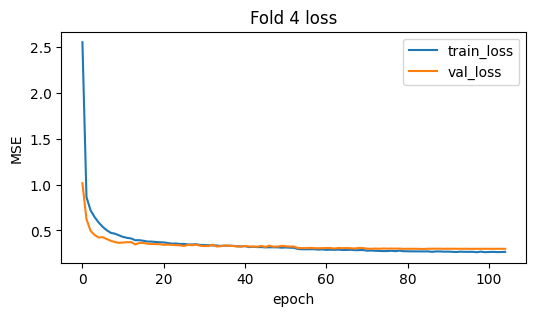


--- Fold 5/5 ---
Epoch 1/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9360 - mse: 3.9360

207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 3.9292 - mse: 3.9292 - val_loss: 0.8064 - val_mse: 0.8064 - learning_rate: 0.0010
Epoch 2/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8982 - mse: 0.8982

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8960 - mse: 0.8960 - val_loss: 0.5436 - val_mse: 0.5436 - learning_rate: 0.0010
Epoch 3/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7221 - mse: 0.7221

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7217 - mse: 0.7217 - val_loss: 0.4930 - val_mse: 0.4930 - learning_rate: 0.0010
Epoch 4/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6179 - mse: 0.6179

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6181 - mse: 0.6181 - val_loss: 0.4248 - val_mse: 0.4248 - learning_rate: 0.0010
Epoch 5/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5723 - mse: 0.5723

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5725 - mse: 0.5725 - val_loss: 0.4084 - val_mse: 0.4084 - learning_rate: 0.0010
Epoch 6/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5262 - mse: 0.5262

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5269 - mse: 0.5269 - val_loss: 0.3788 - val_mse: 0.3788 - learning_rate: 0.0010
Epoch 7/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5028 - mse: 0.5028 - val_loss: 0.3816 - val_mse: 0.3816 - learning_rate: 0.0010
Epoch 8/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4750 - mse: 0.4750 - val_loss: 0.3872 - val_mse: 0.3872 - learning_rate: 0.0010
Epoch 9/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4648 - mse: 0.4648

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4649 - mse: 0.4649 - val_loss: 0.3774 - val_mse: 0.3774 - learning_rate: 0.0010
Epoch 10/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4431 - mse: 0.4431

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4433 - mse: 0.4433 - val_loss: 0.3618 - val_mse: 0.3618 - learning_rate: 0.0010
Epoch 11/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4300 - mse: 0.4300

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4305 - mse: 0.4305 - val_loss: 0.3527 - val_mse: 0.3527 - learning_rate: 0.0010
Epoch 12/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4158 - mse: 0.4158

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4164 - mse: 0.4164 - val_loss: 0.3482 - val_mse: 0.3482 - learning_rate: 0.0010
Epoch 13/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4138 - mse: 0.4138

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4136 - mse: 0.4136 - val_loss: 0.3296 - val_mse: 0.3296 - learning_rate: 0.0010
Epoch 14/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4032 - mse: 0.4032 - val_loss: 0.3355 - val_mse: 0.3355 - learning_rate: 0.0010
Epoch 15/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3904 - mse: 0.3904 - val_loss: 0.3496 - val_mse: 0.3496 - learning_rate: 0.0010
Epoch 16/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3855 - mse: 0.3855

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3857 - mse: 0.3857 - val_loss: 0.3260 - val_mse: 0.3260 - learning_rate: 0.0010
Epoch 17/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3833 - mse: 0.3833

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3834 - mse: 0.3834 - val_loss: 0.3183 - val_mse: 0.3183 - learning_rate: 0.0010
Epoch 18/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3751 - mse: 0.3751 - val_loss: 0.3267 - val_mse: 0.3267 - learning_rate: 0.0010
Epoch 19/200
186/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3666 - mse: 0.3666

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3673 - mse: 0.3673 - val_loss: 0.3179 - val_mse: 0.3179 - learning_rate: 0.0010
Epoch 20/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3686 - mse: 0.3686 - val_loss: 0.3244 - val_mse: 0.3244 - learning_rate: 0.0010
Epoch 21/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3615 - mse: 0.3615 - val_loss: 0.3226 - val_mse: 0.3226 - learning_rate: 0.0010
Epoch 22/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3657 - mse: 0.3657

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3661 - mse: 0.3661 - val_loss: 0.3142 - val_mse: 0.3142 - learning_rate: 0.0010
Epoch 23/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3607 - mse: 0.3607

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3608 - mse: 0.3608 - val_loss: 0.3122 - val_mse: 0.3122 - learning_rate: 0.0010
Epoch 24/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3531 - mse: 0.3531 - val_loss: 0.3170 - val_mse: 0.3170 - learning_rate: 0.0010
Epoch 25/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3543 - mse: 0.3543

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3540 - mse: 0.3540 - val_loss: 0.3057 - val_mse: 0.3057 - learning_rate: 0.0010
Epoch 26/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3512 - mse: 0.3512 - val_loss: 0.3100 - val_mse: 0.3100 - learning_rate: 0.0010
Epoch 27/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3514 - mse: 0.3514

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3513 - mse: 0.3513 - val_loss: 0.3057 - val_mse: 0.3057 - learning_rate: 0.0010
Epoch 28/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3469 - mse: 0.3469 - val_loss: 0.3152 - val_mse: 0.3152 - learning_rate: 0.0010
Epoch 29/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3487 - mse: 0.3487 - val_loss: 0.3162 - val_mse: 0.3162 - learning_rate: 0.0010
Epoch 30/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3359 - mse: 0.3359

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3365 - mse: 0.3365 - val_loss: 0.3018 - val_mse: 0.3018 - learning_rate: 0.0010
Epoch 31/200
197/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3424 - mse: 0.3424

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3425 - mse: 0.3425 - val_loss: 0.3018 - val_mse: 0.3018 - learning_rate: 0.0010
Epoch 32/200
194/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3409 - mse: 0.3409

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3410 - mse: 0.3410 - val_loss: 0.2984 - val_mse: 0.2984 - learning_rate: 0.0010
Epoch 33/200
200/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3330 - mse: 0.3330

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3332 - mse: 0.3332 - val_loss: 0.2975 - val_mse: 0.2975 - learning_rate: 0.0010
Epoch 34/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3354 - mse: 0.3354 - val_loss: 0.3090 - val_mse: 0.3090 - learning_rate: 0.0010
Epoch 35/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3354 - mse: 0.3354

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3354 - mse: 0.3354 - val_loss: 0.2932 - val_mse: 0.2932 - learning_rate: 0.0010
Epoch 36/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3321 - mse: 0.3321 - val_loss: 0.2992 - val_mse: 0.2992 - learning_rate: 0.0010
Epoch 37/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3354 - mse: 0.3354 - val_loss: 0.3021 - val_mse: 0.3021 - learning_rate: 0.0010
Epoch 38/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3315 - mse: 0.3315 - val_loss: 0.2984 - val_mse: 0.2984 - learning_rate: 0.0010
Epoch 39/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3284 - mse: 0.3284 - val_loss: 0.2971 - val_mse: 0.2971 - learning_rate: 0.0010
Epoch 40/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3271 - mse: 0.3271 - val_loss: 0.2964 - val_mse: 0.2964 - learning_rate: 0.0010
Epoch 41/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3233 - mse: 0.3233 - val_loss: 0.2944 - val_mse: 0.2944 - learning_rate: 0.0010
Epoch

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3192 - mse: 0.3192 - val_loss: 0.2867 - val_mse: 0.2867 - learning_rate: 5.0000e-04
Epoch 44/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3095 - mse: 0.3095

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3096 - mse: 0.3096 - val_loss: 0.2853 - val_mse: 0.2853 - learning_rate: 5.0000e-04
Epoch 45/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3106 - mse: 0.3106

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3108 - mse: 0.3108 - val_loss: 0.2825 - val_mse: 0.2825 - learning_rate: 5.0000e-04
Epoch 46/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3108 - mse: 0.3108 - val_loss: 0.2841 - val_mse: 0.2841 - learning_rate: 5.0000e-04
Epoch 47/200
188/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3065 - mse: 0.3065

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3068 - mse: 0.3068 - val_loss: 0.2789 - val_mse: 0.2789 - learning_rate: 5.0000e-04
Epoch 48/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3058 - mse: 0.3058 - val_loss: 0.2799 - val_mse: 0.2799 - learning_rate: 5.0000e-04
Epoch 49/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3078 - mse: 0.3078 - val_loss: 0.2825 - val_mse: 0.2825 - learning_rate: 5.0000e-04
Epoch 50/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3065 - mse: 0.3065 - val_loss: 0.2844 - val_mse: 0.2844 - learning_rate: 5.0000e-04
Epoch 51/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3069 - mse: 0.3069 - val_loss: 0.2852 - val_mse: 0.2852 - learning_rate: 5.0000e-04
Epoch 52/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3044 - mse: 0.3044 - val_loss: 0.2795 - val_mse: 0.2795 - learning_rate: 5.0000e-04
Epoch 53/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3021 - mse: 0.3021 - val_loss: 0.2850 - val_mse: 0.2850 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2994 - mse: 0.2994 - val_loss: 0.2745 - val_mse: 0.2745 - learning_rate: 2.5000e-04
Epoch 56/200
190/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2953 - mse: 0.2953

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2955 - mse: 0.2955 - val_loss: 0.2739 - val_mse: 0.2739 - learning_rate: 2.5000e-04
Epoch 57/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2947 - mse: 0.2947

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2948 - mse: 0.2948 - val_loss: 0.2727 - val_mse: 0.2727 - learning_rate: 2.5000e-04
Epoch 58/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2926 - mse: 0.2926

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2926 - mse: 0.2926 - val_loss: 0.2724 - val_mse: 0.2724 - learning_rate: 2.5000e-04
Epoch 59/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2906 - mse: 0.2906 - val_loss: 0.2749 - val_mse: 0.2749 - learning_rate: 2.5000e-04
Epoch 60/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2964 - mse: 0.2964

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2964 - mse: 0.2964 - val_loss: 0.2705 - val_mse: 0.2705 - learning_rate: 2.5000e-04
Epoch 61/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2940 - mse: 0.2940 - val_loss: 0.2732 - val_mse: 0.2732 - learning_rate: 2.5000e-04
Epoch 62/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2941 - mse: 0.2941

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2940 - mse: 0.2940 - val_loss: 0.2701 - val_mse: 0.2701 - learning_rate: 2.5000e-04
Epoch 63/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2869 - mse: 0.2869 - val_loss: 0.2732 - val_mse: 0.2732 - learning_rate: 2.5000e-04
Epoch 64/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2910 - mse: 0.2910 - val_loss: 0.2711 - val_mse: 0.2711 - learning_rate: 2.5000e-04
Epoch 65/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2900 - mse: 0.2900 - val_loss: 0.2727 - val_mse: 0.2727 - learning_rate: 2.5000e-04
Epoch 66/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2914 - mse: 0.2914 - val_loss: 0.2714 - val_mse: 0.2714 - learning_rate: 2.5000e-04
Epoch 67/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2868 - mse: 0.2868

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2870 - mse: 0.2870 - val_loss: 0.2685 - val_mse: 0.2685 - learning_rate: 2.5000e-04
Epoch 68/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2894 - mse: 0.2894 - val_loss: 0.2708 - val_mse: 0.2708 - learning_rate: 2.5000e-04
Epoch 69/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2937 - mse: 0.2937 - val_loss: 0.2712 - val_mse: 0.2712 - learning_rate: 2.5000e-04
Epoch 70/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2874 - mse: 0.2874 - val_loss: 0.2706 - val_mse: 0.2706 - learning_rate: 2.5000e-04
Epoch 71/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2834 - mse: 0.2834 - val_loss: 0.2717 - val_mse: 0.2717 - learning_rate: 2.5000e-04
Epoch 72/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2924 - mse: 0.2924 - val_loss: 0.2720 - val_mse: 0.2720 - learning_rate: 2.5000e-04
Epoch 73/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2864 - mse: 0.2864 - val_loss: 0.2705 - val_mse: 0.2705 - lea

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2849 - mse: 0.2849 - val_loss: 0.2676 - val_mse: 0.2676 - learning_rate: 1.2500e-04
Epoch 78/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2823 - mse: 0.2823 - val_loss: 0.2679 - val_mse: 0.2679 - learning_rate: 1.2500e-04
Epoch 79/200
192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2826 - mse: 0.2826

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2827 - mse: 0.2827 - val_loss: 0.2672 - val_mse: 0.2672 - learning_rate: 1.2500e-04
Epoch 80/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2828 - mse: 0.2828 - val_loss: 0.2686 - val_mse: 0.2686 - learning_rate: 1.2500e-04
Epoch 81/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2836 - mse: 0.2836 - val_loss: 0.2674 - val_mse: 0.2674 - learning_rate: 1.2500e-04
Epoch 82/200
191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2815 - mse: 0.2815

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2816 - mse: 0.2816 - val_loss: 0.2666 - val_mse: 0.2666 - learning_rate: 1.2500e-04
Epoch 83/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2804 - mse: 0.2804 - val_loss: 0.2678 - val_mse: 0.2678 - learning_rate: 1.2500e-04
Epoch 84/200
189/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2821 - mse: 0.2821

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2822 - mse: 0.2822 - val_loss: 0.2664 - val_mse: 0.2664 - learning_rate: 1.2500e-04
Epoch 85/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2819 - mse: 0.2819

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2819 - mse: 0.2819 - val_loss: 0.2663 - val_mse: 0.2663 - learning_rate: 1.2500e-04
Epoch 86/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2802 - mse: 0.2802 - val_loss: 0.2674 - val_mse: 0.2674 - learning_rate: 1.2500e-04
Epoch 87/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2800 - mse: 0.2800 - val_loss: 0.2667 - val_mse: 0.2667 - learning_rate: 1.2500e-04
Epoch 88/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2804 - mse: 0.2804 - val_loss: 0.2665 - val_mse: 0.2665 - learning_rate: 1.2500e-04
Epoch 89/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2778 - mse: 0.2778 - val_loss: 0.2667 - val_mse: 0.2667 - learning_rate: 1.2500e-04
Epoch 90/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2794 - mse: 0.2794 - val_loss: 0.2667 - val_mse: 0.2667 - learning_rate: 1.2500e-04
Epoch 91/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2795 - mse: 0.2795
Epoch 91: ReduceLROnPlateau reducing learn

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2774 - mse: 0.2774 - val_loss: 0.2653 - val_mse: 0.2653 - learning_rate: 6.2500e-05
Epoch 93/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2775 - mse: 0.2775 - val_loss: 0.2655 - val_mse: 0.2655 - learning_rate: 6.2500e-05
Epoch 94/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2784 - mse: 0.2784 - val_loss: 0.2653 - val_mse: 0.2653 - learning_rate: 6.2500e-05
Epoch 95/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2784 - mse: 0.2784 - val_loss: 0.2656 - val_mse: 0.2656 - learning_rate: 6.2500e-05
Epoch 96/200
195/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2758 - mse: 0.2758

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2758 - mse: 0.2758 - val_loss: 0.2646 - val_mse: 0.2646 - learning_rate: 6.2500e-05
Epoch 97/200
205/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2783 - mse: 0.2783

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2783 - mse: 0.2783 - val_loss: 0.2642 - val_mse: 0.2642 - learning_rate: 6.2500e-05
Epoch 98/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2833 - mse: 0.2833 - val_loss: 0.2644 - val_mse: 0.2644 - learning_rate: 6.2500e-05
Epoch 99/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2773 - mse: 0.2773 - val_loss: 0.2645 - val_mse: 0.2645 - learning_rate: 6.2500e-05
Epoch 100/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2770 - mse: 0.2770 - val_loss: 0.2651 - val_mse: 0.2651 - learning_rate: 6.2500e-05
Epoch 101/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2742 - mse: 0.2742 - val_loss: 0.2646 - val_mse: 0.2646 - learning_rate: 6.2500e-05
Epoch 102/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2790 - mse: 0.2790 - val_loss: 0.2652 - val_mse: 0.2652 - learning_rate: 6.2500e-05
Epoch 103/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2727 - mse: 0.2727 - val_loss: 0.2652 - val_mse: 0.2652 -

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2721 - mse: 0.2721 - val_loss: 0.2642 - val_mse: 0.2642 - learning_rate: 3.1250e-05
Epoch 110/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2732 - mse: 0.2732 - val_loss: 0.2646 - val_mse: 0.2646 - learning_rate: 3.1250e-05
Epoch 111/200
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2769 - mse: 0.2769
Epoch 111: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2769 - mse: 0.2769 - val_loss: 0.2644 - val_mse: 0.2644 - learning_rate: 3.1250e-05
Epoch 112/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2732 - mse: 0.2732 - val_loss: 0.2645 - val_mse: 0.2645 - learning_rate: 1.5625e-05
Epoch 113/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2765 - mse: 0.2765 - val_loss: 0.2644 - val_mse: 0.2644 - learning_rate: 1.5625e-05
Epoch 114/200
193/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2735 - mse: 0.2735

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2735 - mse: 0.2735 - val_loss: 0.2638 - val_mse: 0.2638 - learning_rate: 1.5625e-05
Epoch 115/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2734 - mse: 0.2734 - val_loss: 0.2640 - val_mse: 0.2640 - learning_rate: 1.5625e-05
Epoch 116/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2714 - mse: 0.2714 - val_loss: 0.2640 - val_mse: 0.2640 - learning_rate: 1.5625e-05
Epoch 117/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2773 - mse: 0.2773 - val_loss: 0.2640 - val_mse: 0.2640 - learning_rate: 1.5625e-05
Epoch 118/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2765 - mse: 0.2765 - val_loss: 0.2640 - val_mse: 0.2640 - learning_rate: 1.5625e-05
Epoch 119/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2787 - mse: 0.2787

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2786 - mse: 0.2786 - val_loss: 0.2638 - val_mse: 0.2638 - learning_rate: 1.5625e-05
Epoch 120/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2767 - mse: 0.2767 - val_loss: 0.2641 - val_mse: 0.2641 - learning_rate: 1.5625e-05
Epoch 121/200
187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2729 - mse: 0.2729
Epoch 121: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2731 - mse: 0.2731 - val_loss: 0.2640 - val_mse: 0.2640 - learning_rate: 1.5625e-05
Epoch 122/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2758 - mse: 0.2758 - val_loss: 0.2641 - val_mse: 0.2641 - learning_rate: 7.8125e-06
Epoch 123/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2722 - mse: 0.2722 - val_loss: 0.2640 - val_mse: 0.2640 - learning_rate: 7.8125e-06
Epoch 124/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2693 - mse: 0.2693 - val_loss: 0.2639 - val_mse: 0.2639 

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2713 - mse: 0.2713 - val_loss: 0.2637 - val_mse: 0.2637 - learning_rate: 7.8125e-06
Epoch 128/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2741 - mse: 0.2741 - val_loss: 0.2638 - val_mse: 0.2638 - learning_rate: 7.8125e-06
Epoch 129/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2753 - mse: 0.2753 - val_loss: 0.2640 - val_mse: 0.2640 - learning_rate: 7.8125e-06
Epoch 130/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2719 - mse: 0.2719 - val_loss: 0.2638 - val_mse: 0.2638 - learning_rate: 7.8125e-06
Epoch 131/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2744 - mse: 0.2744 - val_loss: 0.2638 - val_mse: 0.2638 - learning_rate: 7.8125e-06
Epoch 132/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2759 - mse: 0.2759 - val_loss: 0.2640 - val_mse: 0.2640 - learning_rate: 7.8125e-06
Epoch 133/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2737 - mse: 0.2737 - val_loss: 0.2639 - val_mse: 0.2639

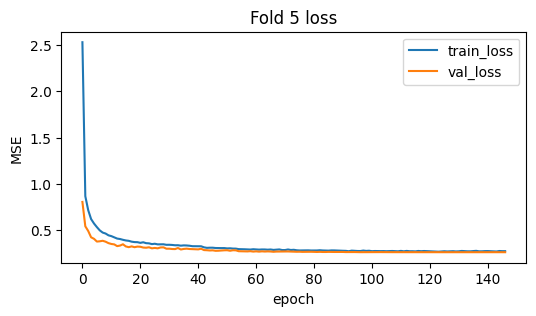


CV folds MSE per fold: [0.28820163954902056, 0.2969635977901103, 0.27641095790343934, 0.29831478177789456, 0.2637021195897943]
OOF CV MSE: 0.28471957184135266


In [26]:
# 3) Cross-validated training 

N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X_train_proc))
test_preds_folds = []  # store fold predictions for ensembling
fold_metrics = []

# training hyperparams (tweakable)
BATCH_SIZE = 64
EPOCHS = 200
PATIENCE = 20
LR = 1e-3

if USE_TF:
    import tensorflow as tf
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train_proc, y), 1):
        print(f"\n--- Fold {fold}/{N_FOLDS} ---")
        X_tr, X_val = X_train_proc.iloc[tr_idx].values, X_train_proc.iloc[val_idx].values
        y_tr, y_val = y[tr_idx], y[val_idx]

        # build fresh model for each fold
        model = build_keras_model(input_dim=X_tr.shape[1], hidden_units=(128,64), dropout=0.15, lr=LR)

        # callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, verbose=1, min_lr=1e-6),
        ]
        # optional: checkpoint (save best model file per fold)
        ckpt_path = os.path.join(ARTIFACT_DIR, f"keras_fold{fold}_best.h5")
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, save_weights_only=False, verbose=0))

        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=callbacks,
            verbose=1
        )

        # predict OOF & test
        val_pred = model.predict(X_val).ravel()
        oof_preds[val_idx] = val_pred
        fold_mse = mean_squared_error(y_val, val_pred)
        fold_metrics.append(fold_mse)
        print(f"Fold {fold} val MSE: {fold_mse:.6f}")

        # test preds for fold
        test_fold_pred = model.predict(X_test_proc.values).ravel()
        test_preds_folds.append(test_fold_pred)

        # plot training curve for fold (loss)
        plt.figure(figsize=(6,3))
        plt.plot(history.history["loss"], label="train_loss")
        plt.plot(history.history["val_loss"], label="val_loss")
        plt.title(f"Fold {fold} loss")
        plt.xlabel("epoch")
        plt.ylabel("MSE")
        plt.legend()
        plt.show()

    # CV summary
    oof_mse = mean_squared_error(y, oof_preds)
    print("\nCV folds MSE per fold:", fold_metrics)
    print("OOF CV MSE:", oof_mse)

    # Ensemble test preds: average across folds
    test_preds = np.mean(np.column_stack(test_preds_folds), axis=1)
else:
    # sklearn MLP fallback (single-run cross-validated)
    from sklearn.neural_network import MLPRegressor
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train_proc, y), 1):
        print(f"\n--- Fold {fold}/{N_FOLDS} (sklearn MLP) ---")
        X_tr, X_val = X_train_proc.iloc[tr_idx].values, X_train_proc.iloc[val_idx].values
        y_tr, y_val = y[tr_idx], y[val_idx]

        mlp = MLPRegressor(hidden_layer_sizes=(128,64), activation="relu", solver="adam",
                           early_stopping=True, validation_fraction=0.15, n_iter_no_change=20,
                           max_iter=1000, random_state=42)
        mlp.fit(X_tr, y_tr)
        val_pred = mlp.predict(X_val)
        oof_preds[val_idx] = val_pred
        fold_mse = mean_squared_error(y_val, val_pred)
        fold_metrics.append(fold_mse)
        print(f"Fold {fold} val MSE: {fold_mse:.6f}")

        test_fold_pred = mlp.predict(X_test_proc.values)
        test_preds_folds.append(test_fold_pred)

    oof_mse = mean_squared_error(y, oof_preds)
    print("\nCV folds MSE per fold:", fold_metrics)
    print("OOF CV MSE:", oof_mse)

    test_preds = np.mean(np.column_stack(test_preds_folds), axis=1)

Saved OOF predictions: artifacts/oof_predictions.csv
Saved final submission to submission.csv


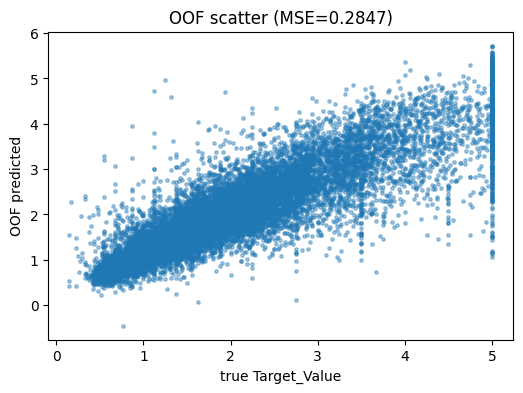

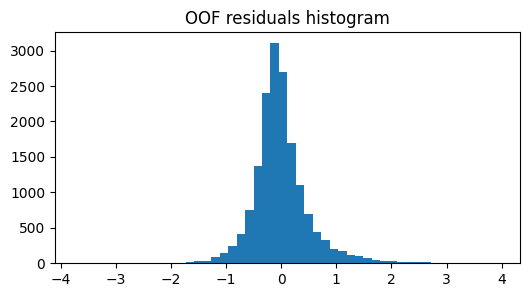

In [27]:
# 4) Save OOF, fold metrics, and submission 

# OOF dataframe
oof_df = pd.DataFrame({"ID": train_ids, "Target_Value_pred": oof_preds})
oof_df.to_csv(os.path.join(ARTIFACT_DIR, "oof_predictions.csv"), index=False)
print("Saved OOF predictions:", os.path.join(ARTIFACT_DIR, "oof_predictions.csv"))

# Fold metrics
pd.DataFrame({"fold_mse": fold_metrics}).to_csv(os.path.join(ARTIFACT_DIR, "fold_metrics.csv"), index=False)

# Final submission (average of folds)
submission = pd.DataFrame({"ID": test_ids, "Target_Value": test_preds})
submission_path = "submission.csv"
submission.to_csv(submission_path, index=False)
print("Saved final submission to", submission_path)

# Quick diagnostics plots and residual distribution
plt.figure(figsize=(6,4))
plt.scatter(y, oof_preds, alpha=0.4, s=6)
plt.xlabel("true Target_Value")
plt.ylabel("OOF predicted")
plt.title(f"OOF scatter (MSE={oof_mse:.4f})")
plt.show()

plt.figure(figsize=(6,3))
plt.hist((y - oof_preds), bins=50)
plt.title("OOF residuals histogram")
plt.show()

# Notebook Block 4: Performance experiments (log-target, seed-ensembling, Huber loss, stacking)

Loaded processed CSVs.
TensorFlow detected: 2.19.0

Experiment=baseline_mse  Fold 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 Fold 1 MSE: 0.292834

Experiment=baseline_mse  Fold 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 Fold 2 MSE: 0.296762

Experiment=baseline_mse  Fold 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 Fold 3 MSE: 0.269101

Experiment=baseline_mse  Fold 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 Fold 4 MSE: 0.296613

Experiment=baseline_mse  Fold 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 Fold 5 MSE: 0.268129

Experiment baseline_mse OOF MSE: 0.284689

Experiment=log_target  Fold 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 Fold 1 MSE: 0.291002

Experiment=log_target  Fold 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,experiment,oof_mse,mean_fold_mse,fold_mses
4,stacking,0.275207,NaN,[]
3,seed_ensemble,0.276227,0.276226,"[0.28110047301956653, 0.28889349838546585, 0.2..."
2,huber_loss,0.278268,0.278267,"[0.28721943975853187, 0.2924571330520191, 0.25..."
0,baseline_mse,0.284689,0.284688,"[0.29283445811152586, 0.2967621761879068, 0.26..."
1,log_target,0.286060,0.286058,"[0.2910021685334186, 0.30206473625880603, 0.27..."


Saved best Block4 submission: submission_block4_stacking.csv
Best experiment: stacking OOF MSE: 0.2752070505009299


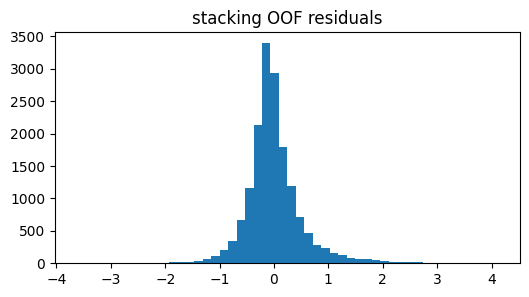

In [28]:
# Notebook Block 4 (updated): Performance experiments (log-target, seed-ensembling, Huber loss, stacking)
import os, math, random
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
import joblib
import matplotlib.pyplot as plt

# reproducible helpers
def set_seed(seed=42):
    import os, random, numpy as _np
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    _np.random.seed(seed)
    try:
        import tensorflow as _tf
        _tf.random.set_seed(seed)
    except Exception:
        pass

set_seed(42)

# Paths (adjust if needed)
ARTIFACT_DIR = "artifacts"
PIPELINE_JOBLIB = os.path.join(ARTIFACT_DIR, "preprocessing_pipeline.joblib")
X_TRAIN_PROC_CSV = os.path.join(ARTIFACT_DIR, "X_train_processed.csv")
X_TEST_PROC_CSV  = os.path.join(ARTIFACT_DIR, "X_test_processed.csv")
RAW_TRAIN_PATH = "/kaggle/input/applai-26-nn-competition/train.csv"
RAW_TEST_PATH  = "/kaggle/input/applai-26-nn-competition/test.csv"

# Load raw & processed data
train_raw = pd.read_csv(RAW_TRAIN_PATH)
test_raw  = pd.read_csv(RAW_TEST_PATH)
ID_COL = "ID"
TARGET_COL = "Target_Value"

# load processed features if available, else apply pipeline
if os.path.exists(X_TRAIN_PROC_CSV) and os.path.exists(X_TEST_PROC_CSV):
    X_train_proc = pd.read_csv(X_TRAIN_PROC_CSV)
    X_test_proc  = pd.read_csv(X_TEST_PROC_CSV)
    print("Loaded processed CSVs.")
else:
    assert os.path.exists(PIPELINE_JOBLIB), "Run Block 2 first to produce preprocessing artifacts."
    fitted = joblib.load(PIPELINE_JOBLIB)
    ua = fitted["unit_aligner"]
    bsplit = fitted["bimodal_splitter"]
    imputer = fitted["imputer"]
    clipper = fitted["clipper"]
    scaler = fitted["scaler"]
    final_cols = fitted["final_cols"]
    log_cols = fitted.get("log_cols", [])
    # apply pipeline to raw
    X_raw = train_raw[[c for c in train_raw.columns if c not in (ID_COL, TARGET_COL)]].copy()
    X_test_raw = test_raw[[c for c in test_raw.columns if c not in (ID_COL, )]].copy()
    try:
        X_raw_al = ua.transform(X_raw)
        X_test_al = ua.transform(X_test_raw)
    except Exception:
        X_raw_al = X_raw.copy(); X_test_al = X_test_raw.copy()
    X_raw_split = bsplit.transform(X_raw_al)
    X_test_split = bsplit.transform(X_test_al)
    X_train_proc = pd.DataFrame(imputer.transform(X_raw_split[final_cols]), columns=final_cols)
    X_test_proc  = pd.DataFrame(imputer.transform(X_test_split[final_cols]), columns=final_cols)
    for c in log_cols:
        if (X_train_proc[c] >= 0).all():
            X_train_proc[c] = np.log1p(X_train_proc[c]); X_test_proc[c] = np.log1p(X_test_proc[c])
    X_train_proc = clipper.transform(X_train_proc)
    X_test_proc = clipper.transform(X_test_proc)
    X_train_proc = pd.DataFrame(scaler.transform(X_train_proc), columns=final_cols)
    X_test_proc = pd.DataFrame(scaler.transform(X_test_proc), columns=final_cols)
    print("Applied pipeline to create processed sets.")

y = train_raw[TARGET_COL].values
train_ids = train_raw[ID_COL].values
test_ids  = test_raw[ID_COL].values

# KFold config
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# safety: ensure shapes aligned
assert X_train_proc.shape[0] == len(y)

# Try TF availability
USE_TF = True
try:
    import tensorflow as tf
    print("TensorFlow detected:", tf.__version__)
except Exception:
    USE_TF = False
    print("TensorFlow not available, falling back to sklearn training for experiments.")

# small keras builder (same as block3)
def build_keras_model(input_dim, hidden_units=(128,64), dropout=0.15, lr=1e-3, loss="mse"):
    if not USE_TF:
        raise RuntimeError("TensorFlow not available.")
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam
    model = Sequential()
    model.add(Dense(hidden_units[0], activation="relu", input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(hidden_units[1], activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout/2))
    model.add(Dense(1, activation="linear"))
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=loss, metrics=["mse"])
    return model

# Core function: run K-Fold training for one experiment setup and return oof preds & test preds
def run_experiment(name,
                   X, y,
                   test_X,
                   model_builder,       # if use_tf True: function(input_dim)->compiled keras model
                                        # if use_tf False: function() -> sklearn estimator instance (factory)
                   transform_target=None,  # dict with keys {"fwd":fn, "inv":fn} or None
                   seeds=[42],          # list of seeds for seed-ensembling (will average)
                   use_tf=USE_TF,
                   verbose=True):
    """
    Runs K-Fold CV. If seeds length>1 and use_tf -> runs a model per seed per fold and averages
    Returns: dict with oof, test_preds, fold_mses, oof_mse
    """
    oof = np.zeros(len(X))
    test_fold_preds = []   # will store per-fold averaged across seeds
    fold_mses = []

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y), 1):
        if verbose: print(f"\nExperiment={name}  Fold {fold}/{N_FOLDS}")
        X_tr_df, X_val_df = X.iloc[tr_idx], X.iloc[val_idx]
        X_tr, X_val = X_tr_df.values, X_val_df.values
        y_tr_orig, y_val_orig = y[tr_idx].copy(), y[val_idx].copy()

        # apply target transform if provided (forward)
        if transform_target is not None:
            y_tr = transform_target["fwd"](y_tr_orig)
            y_val_trans = transform_target["fwd"](y_val_orig)
        else:
            y_tr = y_tr_orig
            y_val_trans = y_val_orig

        # arrays to store seed predictions
        val_preds_seeds = np.zeros((len(seeds), len(val_idx)))
        test_preds_seeds = np.zeros((len(seeds), test_X.shape[0]))

        for si, seed in enumerate(seeds):
            set_seed(seed)
            if use_tf:
                model = model_builder(input_dim=X_tr.shape[1])
                callbacks = [
                    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=0),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, verbose=0, min_lr=1e-6)
                ]
                # train with transformed target y_tr and validation using y_val_trans
                hist = model.fit(X_tr, y_tr, validation_data=(X_val, y_val_trans),
                                 epochs=200, batch_size=64, callbacks=callbacks, verbose=0)
                # predict (predictions are in transformed space if transform applied)
                vpred = model.predict(X_val).ravel()
                tpred = model.predict(test_X.values).ravel()
            else:
                # sklearn estimator factory expected (callable that returns estimator)
                est = model_builder() if callable(model_builder) else model_builder
                # if transform_target provided, y_tr is already transformed above
                est.fit(X_tr, y_tr)
                vpred = est.predict(X_val)
                tpred = est.predict(test_X.values)

            val_preds_seeds[si] = vpred
            test_preds_seeds[si] = tpred

        # average seeds (per fold)
        val_pred_avg = val_preds_seeds.mean(axis=0)
        test_pred_avg = test_preds_seeds.mean(axis=0)

        # inverse transform the averaged predictions if needed
        if transform_target is not None:
            inv_fn = transform_target["inv"]
            val_pred_avg = inv_fn(val_pred_avg)
            test_pred_avg = inv_fn(test_pred_avg)

        # store oof and fold test preds
        oof[val_idx] = val_pred_avg
        test_fold_preds.append(test_pred_avg)

        fold_mse = mean_squared_error(y_val_orig, val_pred_avg)
        fold_mses.append(fold_mse)
        if verbose: print(f" Fold {fold} MSE: {fold_mse:.6f}")

    # average test predictions across folds
    test_preds = np.mean(np.column_stack(test_fold_preds), axis=1)
    oof_mse = mean_squared_error(y, oof)
    if verbose:
        print(f"\nExperiment {name} OOF MSE: {oof_mse:.6f}")
    return {"name": name, "oof": oof, "test_preds": test_preds, "fold_mses": fold_mses, "oof_mse": oof_mse}

# ---- Experiment definitions ----
experiments_to_run = [
    "baseline_mse",     # baseline from Block 3 (mse, original target)
    "log_target",       # train on log1p(target)
    "huber_loss",       # same model but Huber loss
    "seed_ensemble",    # seed ensemble (3 seeds)
    "stacking"          # stacking (meta-learner combining baseline & log_target & huber)
]

results = {}

# Baseline builder (Keras MSE)
def baseline_builder(input_dim):
    return build_keras_model(input_dim=input_dim, hidden_units=(128,64), dropout=0.15, lr=1e-3, loss="mse")

# Huber builder (Keras with Huber) - only valid if USE_TF True
if USE_TF:
    def huber_builder(input_dim):
        return build_keras_model(input_dim=input_dim, hidden_units=(128,64), dropout=0.15, lr=1e-3, loss=tf.keras.losses.Huber(delta=1.0))

# For sklearn fallback: a simple MLPRegressor factory (no args)
def sklearn_mlp_factory():
    from sklearn.neural_network import MLPRegressor
    return MLPRegressor(hidden_layer_sizes=(128,64), activation="relu", solver="adam", early_stopping=True,
                        validation_fraction=0.15, n_iter_no_change=20, max_iter=1000, random_state=42)

# Transform target functions: dict with 'fwd' & 'inv'
log_transform = {"fwd": lambda y: np.log1p(y), "inv": lambda yp: np.expm1(yp)}

# Run experiments (choose model functions automatically based on USE_TF)
use_tf = USE_TF

# 1) baseline (single seed)
if "baseline_mse" in experiments_to_run:
    if use_tf:
        results["baseline_mse"] = run_experiment("baseline_mse", X_train_proc, y, X_test_proc, model_builder=baseline_builder, transform_target=None, seeds=[42], use_tf=True)
    else:
        results["baseline_mse"] = run_experiment("baseline_mse", X_train_proc, y, X_test_proc, model_builder=sklearn_mlp_factory, transform_target=None, seeds=[42], use_tf=False)

# 2) log-target
if "log_target" in experiments_to_run:
    if use_tf:
        results["log_target"] = run_experiment("log_target", X_train_proc, y, X_test_proc, model_builder=baseline_builder, transform_target=log_transform, seeds=[42], use_tf=True)
    else:
        results["log_target"] = run_experiment("log_target", X_train_proc, y, X_test_proc, model_builder=sklearn_mlp_factory, transform_target=log_transform, seeds=[42], use_tf=False)

# 3) huber loss
if "huber_loss" in experiments_to_run:
    if use_tf:
        results["huber_loss"] = run_experiment("huber_loss", X_train_proc, y, X_test_proc, model_builder=huber_builder, transform_target=None, seeds=[42], use_tf=True)
    else:
        # sklearn fallback: use HuberRegressor as alternative
        from sklearn.linear_model import HuberRegressor
        def huber_sklearn_factory():
            return HuberRegressor()
        results["huber_loss"] = run_experiment("huber_loss", X_train_proc, y, X_test_proc, model_builder=huber_sklearn_factory, transform_target=None, seeds=[42], use_tf=False)

# 4) seed_ensemble (3 seeds)
if "seed_ensemble" in experiments_to_run:
    seeds = [42, 2023, 7]
    if use_tf:
        results["seed_ensemble"] = run_experiment("seed_ensemble", X_train_proc, y, X_test_proc, model_builder=baseline_builder, transform_target=None, seeds=seeds, use_tf=True)
    else:
        # sklearn path: run multiple seeded runs and average
        temp_preds = []
        temp_oofs = []
        temp_fold_mses = []
        for s in seeds:
            # build a factory that returns an MLP with that random_state
            def mlp_factory_with_seed(s_local=s):
                from sklearn.neural_network import MLPRegressor
                return MLPRegressor(hidden_layer_sizes=(128,64), activation="relu", solver="adam", early_stopping=True,
                                    validation_fraction=0.15, n_iter_no_change=20, max_iter=1000, random_state=int(s_local))
            res_s = run_experiment(f"seed_{s}", X_train_proc, y, X_test_proc, model_builder=mlp_factory_with_seed, transform_target=None, seeds=[s], use_tf=False)
            temp_preds.append(res_s["test_preds"])
            temp_oofs.append(res_s["oof"])
            temp_fold_mses.append(res_s["fold_mses"])
        # average test preds and oofs
        avg_test = np.mean(np.column_stack(temp_preds), axis=1)
        avg_oof = np.mean(np.column_stack(temp_oofs), axis=1)
        avg_fold_mses = np.mean(np.array(temp_fold_mses), axis=0).tolist()
        results["seed_ensemble"] = {"name":"seed_ensemble","oof":avg_oof,"test_preds":avg_test,"fold_mses":avg_fold_mses,"oof_mse":mean_squared_error(y, avg_oof)}

# 5) stacking (meta-learner): combine baseline, log_target, huber
if "stacking" in experiments_to_run:
    base_keys = ["baseline_mse", "log_target", "huber_loss"]
    missing = [k for k in base_keys if k not in results]
    if missing:
        print("Missing base experiments for stacking:", missing)
    else:
        oof_matrix = np.column_stack([results[k]["oof"] for k in base_keys])
        test_matrix = np.column_stack([results[k]["test_preds"] for k in base_keys])
        ridge = RidgeCV(alphas=[0.01,0.1,1.0,5.0,10.0], cv=5)
        ridge.fit(oof_matrix, y)
        meta_oof_pred = ridge.predict(oof_matrix)
        meta_test_pred = ridge.predict(test_matrix)
        meta_mse = mean_squared_error(y, meta_oof_pred)
        print("Stacking meta OOF MSE:", meta_mse)
        results["stacking"] = {"name":"stacking","oof":meta_oof_pred,"test_preds":meta_test_pred,"fold_mses":[],"oof_mse":meta_mse}

# ---- Summarize results ----
summary = []
for k, v in results.items():
    summary.append((k, v["oof_mse"], np.mean(v["fold_mses"]) if len(v["fold_mses"])>0 else np.nan, v["fold_mses"]))
summary_df = pd.DataFrame(summary, columns=["experiment","oof_mse","mean_fold_mse","fold_mses"])
display(summary_df.sort_values("oof_mse"))

# Save best experiment's submission (lowest oof_mse)
best_key = summary_df.sort_values("oof_mse").iloc[0]["experiment"]
best_preds = results[best_key]["test_preds"]
sub = pd.DataFrame({"ID": test_ids, "Target_Value": best_preds})
sub_path = f"submission_block4_{best_key}.csv"
sub.to_csv(sub_path, index=False)
print("Saved best Block4 submission:", sub_path)

# Plot residuals for best
best_oof = results[best_key]["oof"]
print("Best experiment:", best_key, "OOF MSE:", mean_squared_error(y, best_oof))
plt.figure(figsize=(6,3))
plt.hist((y - best_oof), bins=50)
plt.title(f"{best_key} OOF residuals")
plt.show()
